# Лабораторная работа №3

## Градиентный бустинг деревьев решений

Рассмотрим качество работы алгоритмов градиентного бустинга деревьев решений в зависимости от настраиваемых гиперпараметров

В качестве датасета будем использовать данные из [соревнования на Kaggle](https://www.kaggle.com/competitions/playground-series-s4e10/overview) (определение выгодности предоставления кредита по данным из заявки на его получение)

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, f1_score

In [3]:
from imblearn.over_sampling import RandomOverSampler

In [4]:
from core.visualiztion import *
from core.evaluation import *
from core.training import *
from core.reports.ModelInfo import *
from core.reports.TrainingReport import *

Для воспроизводимости экспериментов

In [5]:
random.seed(42)
np.random.seed(42)

## Загрузка и первичный анализ данных

In [6]:
data_path = 'data'

In [7]:
train_df = pd.read_csv(f"{data_path}/train.csv", index_col=0)
train_df.sample(10)

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                          
4657           23          40000                  RENT                0.0   
56440          25          60000              MORTGAGE                9.0   
42117          32          66300                  RENT                0.0   
10849          22          30000                  RENT                0.0   
39395          27          60000                  RENT                1.0   
17557          37          23004                  RENT                0.0   
906            28         131040              MORTGAGE                0.0   
43624          24          65000              MORTGAGE                3.0   
29017          26          71400              MORTGAGE               10.0   
32662          22          28800                  RENT                5.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
id                                                              
4657             MEDICAL          A       3700           8.00   
56440    HOMEIMPROVEMENT          A       5000           8.59   
42117            MEDICAL          B      20000          12.53   
10849  DEBTCONSOLIDATION          B       5000          10.59   
39395            MEDICAL          B       7000          12.21   
17557            VENTURE          B      11500          11.14   
906              MEDICAL          C       8000          13.35   
43624    HOMEIMPROVEMENT          C      10000          13.35   
29017           PERSONAL          D       6000          17.58   
32662          EDUCATION          C       6250          12.73   

       loan_percent_income cb_person_default_on_file  \
id                                                     
4657                  0.09                         N   
56440                 0.08                         N   
42117                 0.26                         N   
10849                 0.17                         N   
39395                 0.12                         N   
17557                 0.48                         N   
906                   0.06                         Y   
43624                 0.15                         N   
29017                 0.08                         Y   
32662                 0.21                         Y   

       cb_person_cred_hist_length  loan_status  
id                                              
4657                            4            0  
56440                           4            0  
42117                           6            1  
10849                           2            0  
39395                          10            0  
17557                          14            1  
906                             5            0  
43624                           3            0  
29017                           4            1  
32662                           2            0

Посмотрим на размер датасета и типы данных столбцов

In [8]:
train_df.shape

(58645, 12)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


Датасет состоит преимущественно из числовых столбцов, также имеется ряд строковых. Рассмотрим числовые характеристики каждых чтобы выделить возможные категориальные столбцы

In [10]:
train_df.describe().T

count          mean           std      min  \
person_age                  58645.0     27.550857      6.033216    20.00   
person_income               58645.0  64046.172871  37931.106979  4200.00   
person_emp_length           58645.0      4.701015      3.959784     0.00   
loan_amnt                   58645.0   9217.556518   5563.807384   500.00   
loan_int_rate               58645.0     10.677874      3.034697     5.42   
loan_percent_income         58645.0      0.159238      0.091692     0.00   
cb_person_cred_hist_length  58645.0      5.813556      4.029196     2.00   
loan_status                 58645.0      0.142382      0.349445     0.00   

                                 25%       50%       75%         max  
person_age                     23.00     26.00     30.00      123.00  
person_income               42000.00  58000.00  75600.00  1900000.00  
person_emp_length               2.00      4.00      7.00      123.00  
loan_amnt                    5000.00   8000.00  12000.00    35000.00  
loan_int_rate                   7.88     10.75     12.99       23.22  
loan_percent_income             0.09      0.14      0.21        0.83  
cb_person_cred_hist_length      3.00      4.00      8.00       30.00  
loan_status                     0.00      0.00      0.00        1.00

Здесь можно заметить, что большинство измерений лежит примерно в одном диапазоне, исключениями являются размер кредита и доход получателя, отличающиеся от остальных значений на порядки. Однако поскольку градиентный бустинг устойчив к разнице в масштабах данных - операцию масштабирования проводить не будем

In [11]:
train_df.select_dtypes(include=["object"]).describe()

person_home_ownership loan_intent loan_grade cb_person_default_on_file
count                  58645       58645      58645                     58645
unique                     4           6          7                         2
top                     RENT   EDUCATION          A                         N
freq                   30594       12271      20984                     49943

По числу уникальных значений у строковых измерений можно сделать вывод, что все они являются категориями, поэтому в дальнейшем мы применим к ним различные операции кодирования

Построим круговые диаграммы для данных категорий и для целевой переменной, чтобы посмотреть на распределение данных по этим измерениям

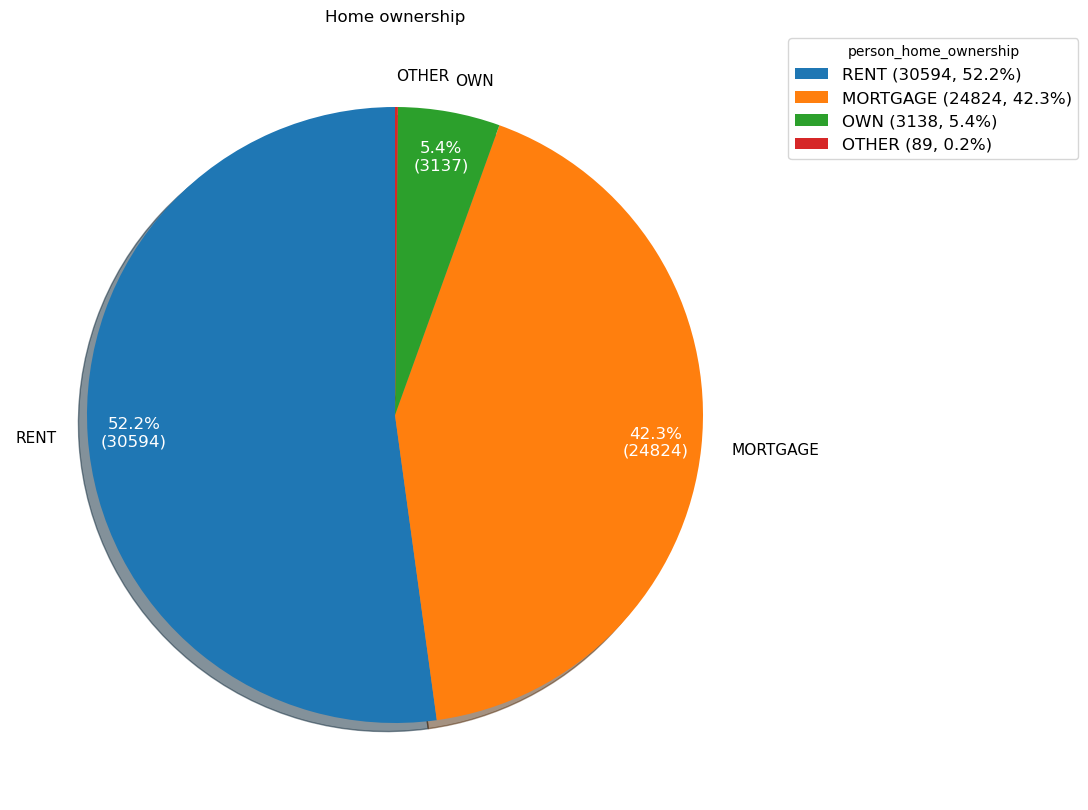

In [12]:
plot_pie_chart(data=train_df, column='person_home_ownership', title='Home ownership')

На диаграмме можно заметить, что подавляющее число кредитополучателей снимают жилье, либо выплачивают ипотеку. Около 5% имеют собственное жилье и об исчезающе малом проценте кредитополучателей (касательно их жилья) информации нет

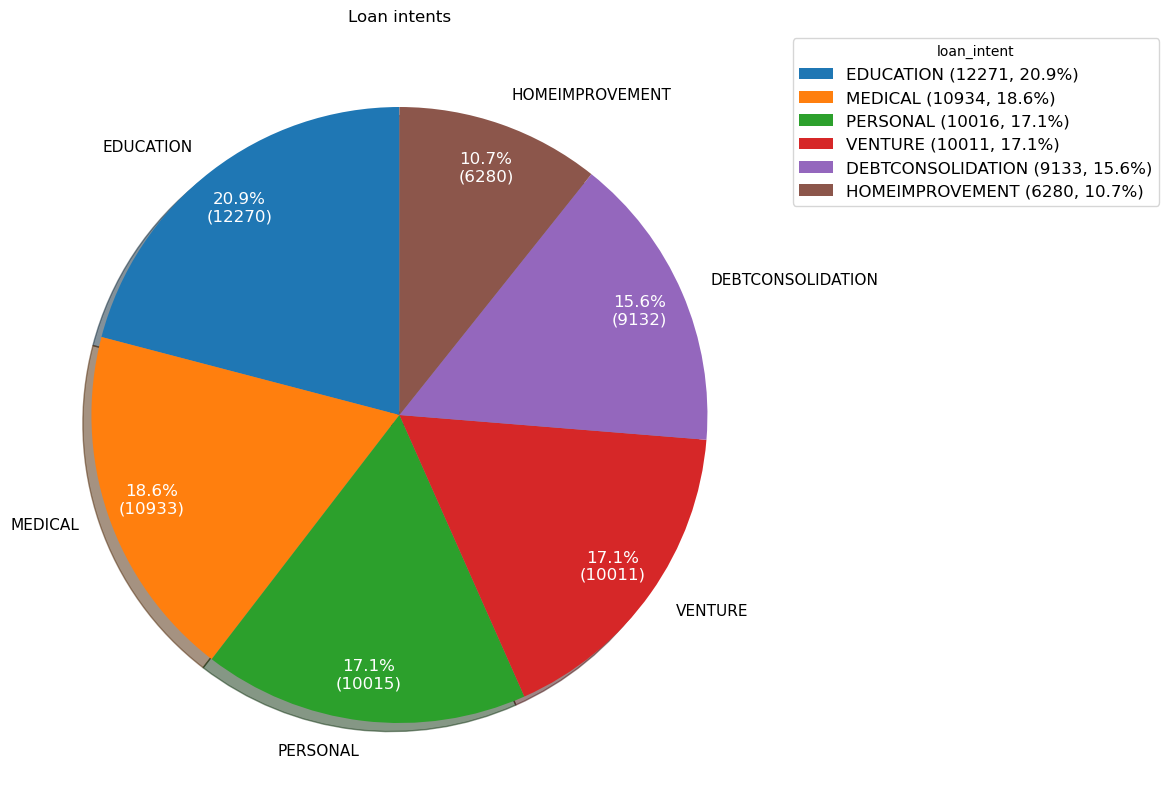

In [13]:
plot_pie_chart(data=train_df, column='loan_intent', title='Loan intents')

Цели, для которых берутся кредиты, распределены примерно равномерно. Наибольшее число кредитов берется на образование, меньшая их часть - на улучшение жилища 

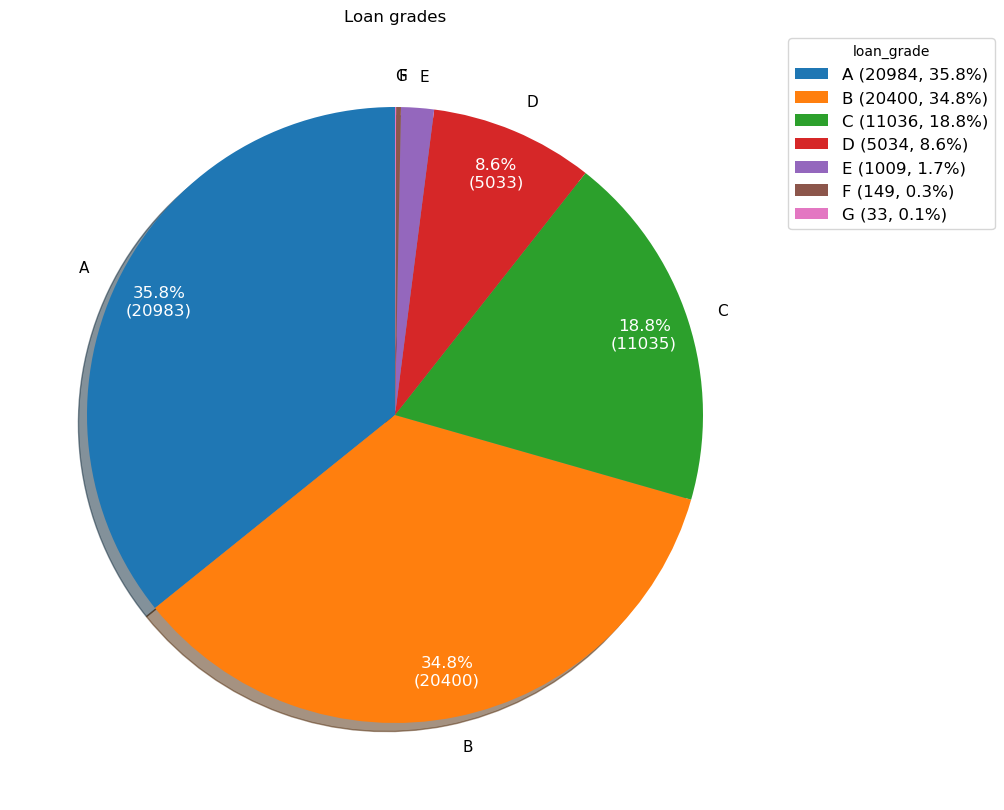

In [14]:
plot_pie_chart(data=train_df, column='loan_grade', title='Loan grades')

Большинство оценок риска для кредитов являются минимальными, оценок, говорящих о большем риске при выдаче кредита, становится все меньше и меньше. Самую "высокую" рискованность имеет 0.1% всех заявок на кредит

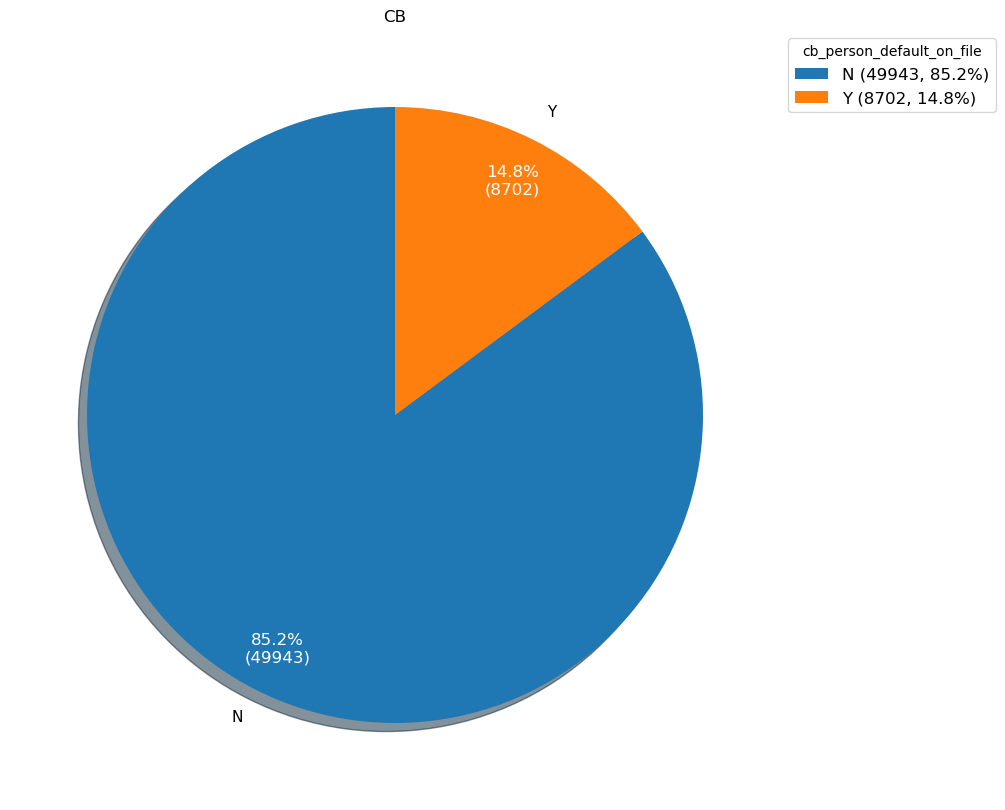

In [15]:
plot_pie_chart(data=train_df, column='cb_person_default_on_file', title='CB')

Подавляющее большинство кредитополучателей не зарегистрированы в базе данных кредитных дефолтов, то есть не имеют просрочек по кредитам

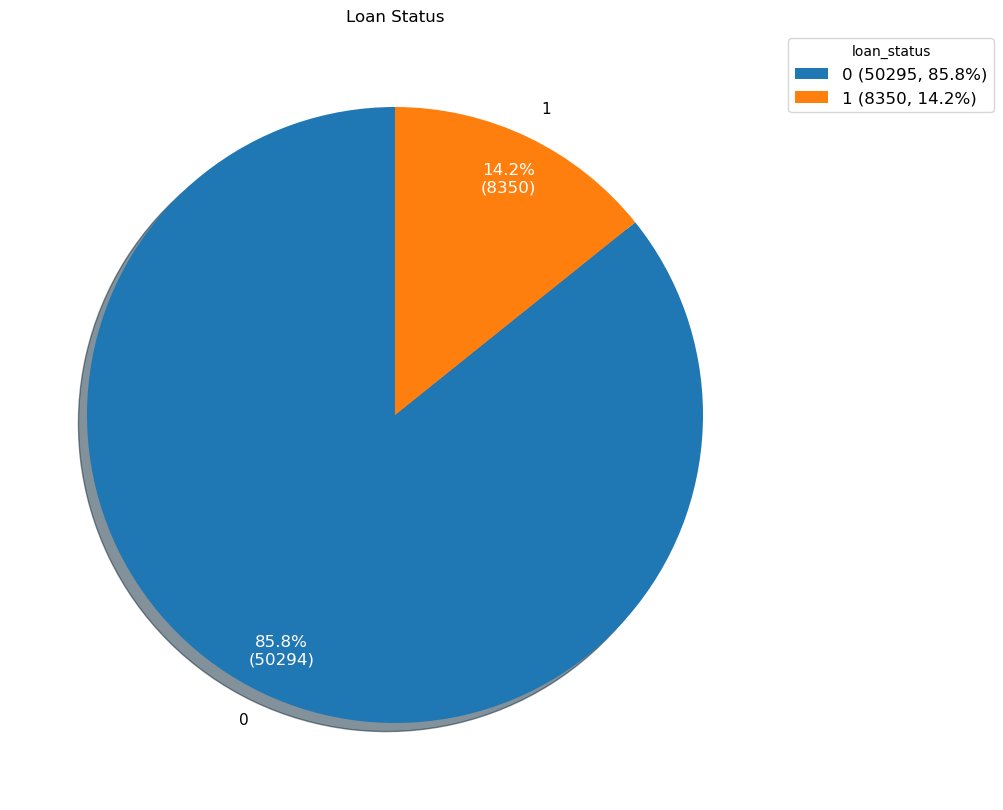

In [16]:
plot_pie_chart(data=train_df, column='loan_status', title='Loan Status')

Целевая переменная (статус кредита) в подавляющем большинстве случаев имеет негативное значение, что говорит нам о том, что необходимо использовать выравнивающие стратегии сэмплирования и/или использовать метрики, устойчивые к скошенному распределению (например `f1_score`)

Поскольку перед нами стоит задача бинарной классификации - мы можем использовать классический `f1_score`. Кроме того, мы будем предсказывать вероятностное распределение классов и оценивать его качество (по вероятности положительного класса) с помощью `roc_auc_score`, что позволяет решать практическую задачу более гибко (использовать threshold'ы), а также продиктовано требованиями соревнования

Посмотрим на корреляции между числовыми переменными

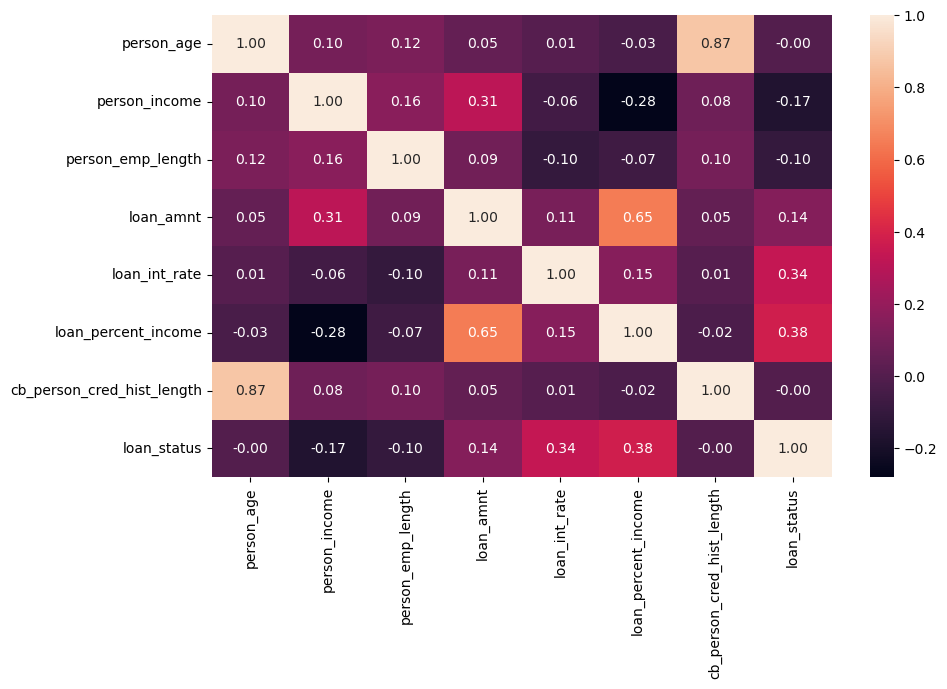

In [17]:
correlations = train_df.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.show()

Большинство корреляций являются слабыми, исключением является связь между размером кредита и отношением суммы кредита к доходу заемщика в процентах, что логично

Поскольку максимальная корреляция не превосходит `0.8` и, кроме того, градиентный бустинг достаточно устойчив к линейным зависимостям между переменными - мы не будем проводить дополнительную обработку данных, направленную на уменьшение коэффициентов корреляции между переменными

## Подготовка данных для обучения модели

Создадим копию исходного датасета

In [18]:
train_df_prepared = train_df.copy()
train_df_prepared.sample(10)

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                          
16328          24          30000                  RENT                2.0   
7071           26          30000                  RENT                1.0   
24272          22          43200                   OWN                7.0   
2439           23          70000                  RENT                7.0   
43592          23         160000              MORTGAGE                7.0   
41325          24          50000                  RENT                5.0   
50768          24          60000                   OWN                2.0   
45377          23          35352              MORTGAGE                4.0   
45874          23          33600                   OWN                8.0   
36844          45          25000                  RENT                0.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
id                                                              
16328  DEBTCONSOLIDATION          A       5000           8.94   
7071            PERSONAL          A       5000           7.29   
24272           PERSONAL          A       6000           7.68   
2439             VENTURE          B       8000          11.49   
43592           PERSONAL          A      11000           7.90   
41325           PERSONAL          A       3000           7.90   
50768            MEDICAL          B       2500          11.99   
45377           PERSONAL          A      10000           5.42   
45874           PERSONAL          B       4000          11.83   
36844          EDUCATION          A       3000           7.51   

       loan_percent_income cb_person_default_on_file  \
id                                                     
16328                 0.17                         N   
7071                  0.17                         N   
24272                 0.14                         N   
2439                  0.11                         N   
43592                 0.07                         N   
41325                 0.06                         N   
50768                 0.04                         N   
45377                 0.29                         N   
45874                 0.12                         N   
36844                 0.12                         N   

       cb_person_cred_hist_length  loan_status  
id                                              
16328                           4            0  
7071                            2            0  
24272                           3            0  
2439                            4            0  
43592                           3            0  
41325                           4            0  
50768                           2            0  
45377                           3            0  
45874                           3            0  
36844                          12            0

Способ владения недвижимостью и цель заема не имеют иерархического порядка следования, потому для их кодировки применим `one_hot_encoding`

In [19]:
one_hot_columns = ['person_home_ownership', 'loan_intent']
train_df_prepared = pd.get_dummies(train_df_prepared, columns=one_hot_columns, drop_first=False)
train_df_prepared.sample(10)

person_age  person_income  person_emp_length loan_grade  loan_amnt  \
id                                                                          
48062          26         140000                5.0          B       6000   
44704          21          30000                5.0          B       3000   
31501          22          36000                3.0          A      10000   
29550          26          95000                1.0          A       6000   
11110          23          36000                2.0          D       6000   
12939          25          45600                2.0          B       5000   
34098          23          55000                6.0          B      12000   
55052          30          67000                9.0          C      20000   
27580          21          55000                6.0          B       5000   
20247          21          45000                3.0          C      10000   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
id                                                                    
48062          12.18                 0.04                         N   
44704          11.49                 0.10                         N   
31501           7.88                 0.28                         N   
29550           8.49                 0.06                         N   
11110          14.96                 0.17                         N   
12939          10.00                 0.11                         N   
34098           9.91                 0.22                         N   
55052          13.92                 0.30                         N   
27580          12.69                 0.09                         N   
20247          13.49                 0.22                         Y   

       cb_person_cred_hist_length  loan_status  \
id                                               
48062                           3            0   
44704                           2            0   
31501                           2            0   
29550                           4            0   
11110                           4            0   
12939                           2            0   
34098                           3            0   
55052                          10            0   
27580                           4            0   
20247                           3            0   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
id                                                                   
48062                            True                        False   
44704                           False                        False   
31501                           False                        False   
29550                            True                        False   
11110                           False                        False   
12939                           False                        False   
34098                           False                        False   
55052                           False                        False   
27580                            True                        False   
20247                           False                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
id                                                             
48062                      False                       False   
44704                      False                        True   
31501                      False                        True   
29550                      False                       False   
11110                      False                        True   
12939                      False                        True   
34098                      False                        True   
55052                      False                        True   
27580                      False                       False   
20247                      False                        True   

       loan_intent

Кредитный риск, выраженный в категориях от A до G имеет иерархический порядок следования, возможный кредит с риском A это не одно и то же, что кредит с риском G, поэтому для кодировки данной переменной применим `ordinal encoding`

Выделим возможные значения категорий и отсортируем их

In [20]:
grades = [np.sort(train_df_prepared['loan_grade'].unique()).tolist()]
grades

[['A', 'B', 'C', 'D', 'E', 'F', 'G']]

Подготовим кодировщик и закодируем данную переменную

In [21]:
ordinal_encoder = OrdinalEncoder(categories=grades)
ordinal_encoder.get_params()

{'categories': [['A', 'B', 'C', 'D', 'E', 'F', 'G']],
 'dtype': numpy.float64,
 'encoded_missing_value': nan,
 'handle_unknown': 'error',
 'max_categories': None,
 'min_frequency': None,
 'unknown_value': None}

In [22]:
train_df_prepared['loan_grade_encoded'] = ordinal_encoder.fit_transform(train_df_prepared[['loan_grade']])
train_df_prepared = train_df_prepared.drop('loan_grade', axis=1)
train_df_prepared.sample(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
id                                                                              
18627          28          54996                7.0      15000           6.92   
52870          21          75000                1.0       9000          12.29   
56749          28          55000                3.0       9600          14.61   
30114          29          65000                0.0       8000           5.42   
19267          22          30000                0.0       4000          11.49   
19420          37          55000                3.0       3200           5.79   
56519          27          71000                6.0      15600          12.87   
46652          26          46800                0.0      10000          12.21   
34658          22          50000                2.0      20000          11.66   
30927          30          70000               14.0       6000          18.39   

       loan_percent_income cb_person_default_on_file  \
id                                                     
18627                 0.27                         N   
52870                 0.12                         Y   
56749                 0.18                         Y   
30114                 0.12                         N   
19267                 0.13                         N   
19420                 0.06                         N   
56519                 0.21                         N   
46652                 0.22                         N   
34658                 0.40                         Y   
30927                 0.09                         N   

       cb_person_cred_hist_length  loan_status  \
id                                               
18627                          10            0   
52870                           2            0   
56749                           6            0   
30114                           9            0   
19267                           4            1   
19420                          12            0   
56519                           5            0   
46652                           4            0   
34658                           3            0   
30927                           7            0   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
id                                                                   
18627                           False                        False   
52870                           False                        False   
56749                           False                        False   
30114                            True                        False   
19267                           False                        False   
19420                            True                        False   
56519                            True                        False   
46652                            True                        False   
34658                           False                        False   
30927                            True                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
id                                                             
18627                       True                       False   
52870                      False                        True   
56749                      False                        True   
30114                      False                       False   
19267                      False                        True   
19420                      False                       False   
56519                      False                       False   
46652                      False                       False   
34658                       True                       False   
30927                      False                       False   

       loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
id                                                            
18627                   

Для кодирования нахождения заемщика в базе данных кредитных дефолтов используем бинарное кодирование

In [23]:
train_df_prepared['cb_person_default_on_file_encoded'] = train_df_prepared['cb_person_default_on_file']\
    .map({'N': False, 'Y': True})
train_df_prepared = train_df_prepared.drop('cb_person_default_on_file', axis=1)
train_df_prepared.sample(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
id                                                                              
57101          25          94500                2.0      14000          10.65   
3695           22          38004                0.0       3900           7.51   
12879          25          24000                2.0       7000          15.05   
26016          26          61440                8.0       6000           7.90   
17839          28          72000                9.0      12000           9.63   
21023          24          52000                8.0      14000           6.91   
51200          35          55000                4.0      15000          10.38   
53389          28          44000                5.0      16000          17.99   
4373           25          48000               10.0       4800           7.51   
3666           23          60629                7.0      10000           7.49   

       loan_percent_income  cb_person_cred_hist_length  loan_status  \
id                                                                    
57101                 0.15                           4            0   
3695                  0.10                           4            0   
12879                 0.29                           3            1   
26016                 0.10                           3            0   
17839                 0.17                           8            0   
21023                 0.27                           3            0   
51200                 0.27                           6            0   
53389                 0.39                           7            1   
4373                  0.10                           3            0   
3666                  0.16                           4            0   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
id                                                                   
57101                            True                        False   
3695                            False                        False   
12879                           False                        False   
26016                            True                        False   
17839                           False                        False   
21023                           False                        False   
51200                            True                        False   
53389                           False                        False   
4373                             True                        False   
3666                             True                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
id                                                             
57101                      False                       False   
3695                        True                       False   
12879                      False                        True   
26016                      False                       False   
17839                      False                        True   
21023                      False                        True   
51200                      False                       False   
53389                      False                        True   
4373                       False                       False   
3666                       False                       False   

       loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
id                                                            
57101                          False                  False   
3695                           False                  False   
12879                           True                  False   
26016                          False                  False   
17839                          False                  False   
21023                          False                  False   
51200                          False                  False   
5338

Вновь посмотрим на типы данных

In [24]:
train_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_age                         58645 non-null  int64  
 1   person_income                      58645 non-null  int64  
 2   person_emp_length                  58645 non-null  float64
 3   loan_amnt                          58645 non-null  int64  
 4   loan_int_rate                      58645 non-null  float64
 5   loan_percent_income                58645 non-null  float64
 6   cb_person_cred_hist_length         58645 non-null  int64  
 7   loan_status                        58645 non-null  int64  
 8   person_home_ownership_MORTGAGE     58645 non-null  bool   
 9   person_home_ownership_OTHER        58645 non-null  bool   
 10  person_home_ownership_OWN          58645 non-null  bool   
 11  person_home_ownership_RENT         58645 non-null  bool   


Как видно, все переменные имеют либо числовой, либо булевый тип данных, что говорит о возможности построения классификатора на имеющихся данных

Выделим признаки и целевую переменную

In [25]:
X = train_df_prepared.drop(columns=['loan_status'])
y = train_df_prepared['loan_status']

Еще раз посмотрим на распределение целевых меток

In [26]:
y.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

Мы видим скошенное распределение, с которым необходимо что-то делать. Воспользуемся технологией оверсэмплинга, клонирующей случайные экземпляры минорного класса до тех пор, пока количество экземпляров классов не сравняется

In [27]:
ros = RandomOverSampler()
X_oversampled, y_oversampled = ros.fit_resample(X, y)

In [28]:
y_oversampled.value_counts()

loan_status
0    50295
1    50295
Name: count, dtype: int64

Теперь классы распределены равномерно

## Обучение классификатора

Разделим данные на тренировочную и тестовую выборки в соотношении 80/20

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42)

В качестве эксперимента мы будем искать оптимальную комбинацию параметров `n_estimators`, `learning_rate`, `loss` и `subsample`. Лучшую модель будем выбирать по `roc_auc_score` на тестовой подвыборке

Укажем перебираемые значения для поиска оптимальной комбинации параметров

In [30]:
trees_numbers = [1000, 800]
learning_rates = [0.1, 0.05, 0.02, 0.25]
losses = ['log_loss', 'exponential']
subsample_sizes = [1, 0.65]

Инициализируем процесс тренировки и выполним ее

In [31]:
trainer = GBModelTrainer(
    train_x=X_train, 
    train_y=y_train, 
    test_x=X_test, 
    test_y=y_test, 
    trees_numbers=trees_numbers, 
    learning_rates=learning_rates, 
    losses=losses, 
    subsample_sizes=subsample_sizes, 
    random_state=42
)

In [32]:
%%time
training_report, best_classifier = trainer.train()

CPU times: total: 45min
Wall time: 45min 15s


После 44-х минут обучения получим следующий отчет

In [33]:
training_report.to_frame()

model_name  train_score  train_f1  \
14   model_log_loss_1000_trees_0.25_lr_0.65_subsample     0.949113  0.948790   
12      model_log_loss_1000_trees_0.25_lr_1_subsample     0.946491  0.946063   
15  model_exponential_1000_trees_0.25_lr_0.65_subs...     0.935630  0.934660   
13   model_exponential_1000_trees_0.25_lr_1_subsample     0.935804  0.934845   
30    model_log_loss_800_trees_0.25_lr_0.65_subsample     0.941769  0.941172   
28       model_log_loss_800_trees_0.25_lr_1_subsample     0.940501  0.939905   
31  model_exponential_800_trees_0.25_lr_0.65_subsa...     0.930833  0.929596   
29    model_exponential_800_trees_0.25_lr_1_subsample     0.930150  0.928874   
2     model_log_loss_1000_trees_0.1_lr_0.65_subsample     0.924421  0.922915   
0        model_log_loss_1000_trees_0.1_lr_1_subsample     0.922557  0.920976   
3   model_exponential_1000_trees_0.1_lr_0.65_subsa...     0.916580  0.914409   
1     model_exponential_1000_trees_0.1_lr_1_subsample     0.914902  0.912617   
18     model_log_loss_800_trees_0.1_lr_0.65_subsample     0.919077  0.917184   
16        model_log_loss_800_trees_0.1_lr_1_subsample     0.917164  0.915243   
19  model_exponential_800_trees_0.1_lr_0.65_subsample     0.910851  0.908200   
17     model_exponential_800_trees_0.1_lr_1_subsample     0.910254  0.907623   
6    model_log_loss_1000_trees_0.05_lr_0.65_subsample     0.907831  0.904950   
4       model_log_loss_1000_trees_0.05_lr_1_subsample     0.906899  0.903954   
7   model_exponential_1000_trees_0.05_lr_0.65_subs...     0.902724  0.899321   
5    model_exponential_1000_trees_0.05_lr_1_subsample     0.901953  0.898474   
22    model_log_loss_800_trees_0.05_lr_0.65_subsample     0.903482  0.900158   
20       model_log_loss_800_trees_0.05_lr_1_subsample     0.902774  0.899339   
23  model_exponential_800_trees_0.05_lr_0.65_subsa...     0.899257  0.895441   
21    model_exponential_800_trees_0.05_lr_1_subsample     0.898499  0.894508   
10   model_log_loss_1000_trees_0.02_lr_0.65_subsample     0.889216  0.884042   
8       model_log_loss_1000_trees_0.02_lr_1_subsample     0.888508  0.883162   
11  model_exponential_1000_trees_0.02_lr_0.65_subs...     0.886582  0.881160   
9    model_exponential_1000_trees_0.02_lr_1_subsample     0.887029  0.881490   
26    model_log_loss_800_trees_0.02_lr_0.65_subsample     0.885115  0.879467   
27  model_exponential_800_trees_0.02_lr_0.65_subsa...     0.882990  0.877252   
24       model_log_loss_800_trees_0.02_lr_1_subsample     0.884357  0.878480   
25    model_exponential_800_trees_0.02_lr_1_subsample     0.882456  0.876189   

    train_roc_auc  test_score   test_f1  test_roc_auc  
14       0.989079    0.937022  0.936380      0.983978  
12       0.988116    0.933592  0.932770      0.983285  
15       0.987643    0.926235  0.924678      0.983188  
13       0.987467    0.926186  0.924700      0.982915  
30       0.986965    0.930112  0.929104      0.982128  
28       0.986083    0.930162  0.929123      0.981760  
31       0.985522    0.921960  0.920045      0.981289  
29       0.985306    0.922159  0.920281      0.981025  
2        0.980350    0.917387  0.915204      0.976681  
0        0.979400    0.916045  0.913822      0.975948  
3        0.978964    0.911174  0.908251      0.975671  
1        0.978174    0.909832  0.906812      0.975257  
18       0.978099    0.912864  0.910208      0.974770  
16       0.977283    0.911423  0.908793      0.974182  
19       0.976606    0.905806  0.902415      0.973643  
17       0.975774    0.905855  0.902401      0.973078  
6        0.972795    0.902625  0.899026      0.969919  
4        0.972163    0.902078  0.898359      0.969715  
7        0.971513    0.898946  0.894756      0.969132  
5        0.970604    0.899244  0.895099      0.968433  
22       0.970406    0.898996  0.894944      0.967840  
20       0.969726    0.898300  0.894132      0.967362  
23       0.969111    0.895914  0.891424      0.966957  
21       0.968226    0.895069  0.890412      0.966256  
10

Лучший результат показали модели, имеющие 1000 деревьев (наибольшее значение из анализируемых), самую высокую скорость обучения, функцию потерь log_loss. Доля обучающей выборки для обучения конкретного решающего дерева большой роли не сыграла, однако меньшие значения показывают чуть лучший результат

Построим графики изменения f1-меры, ROC AUC score и значения функции потерь в зависимости от итерации для каждой из комбинаций параметров

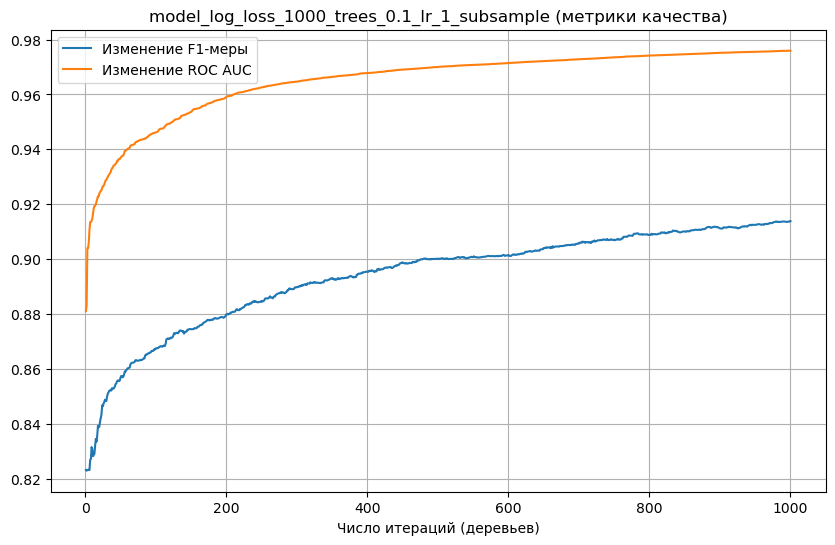

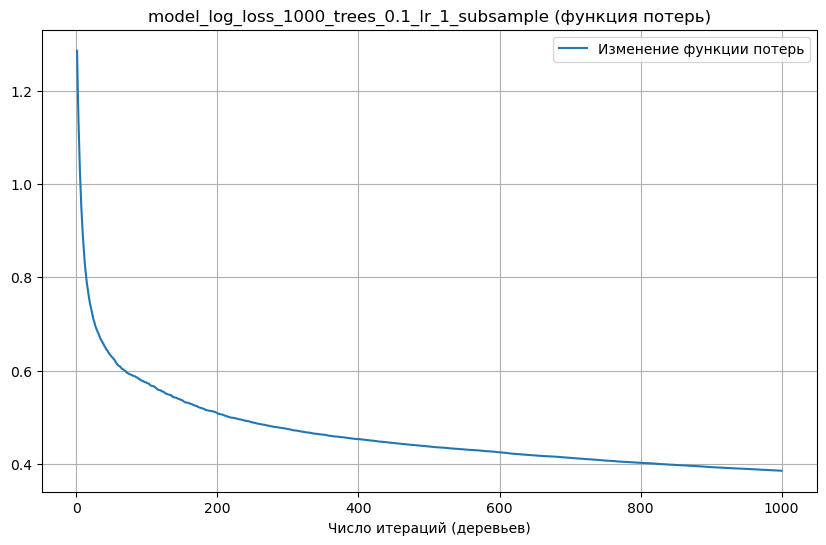

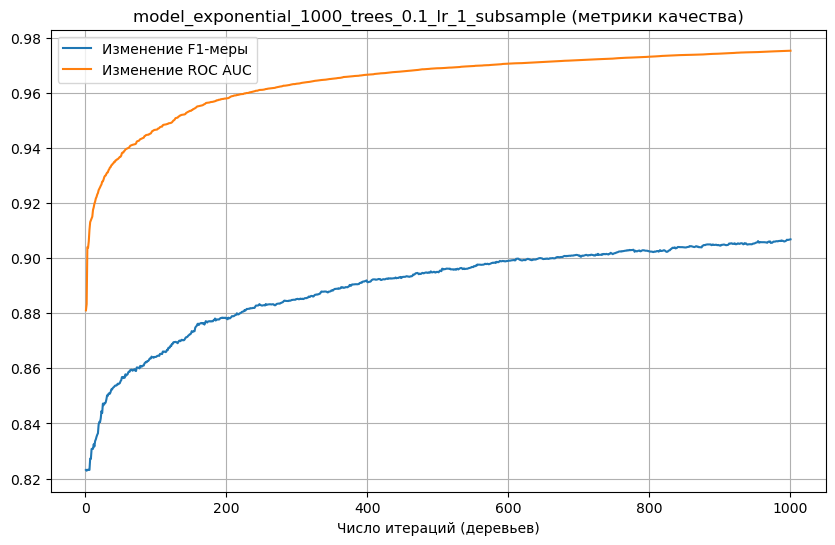

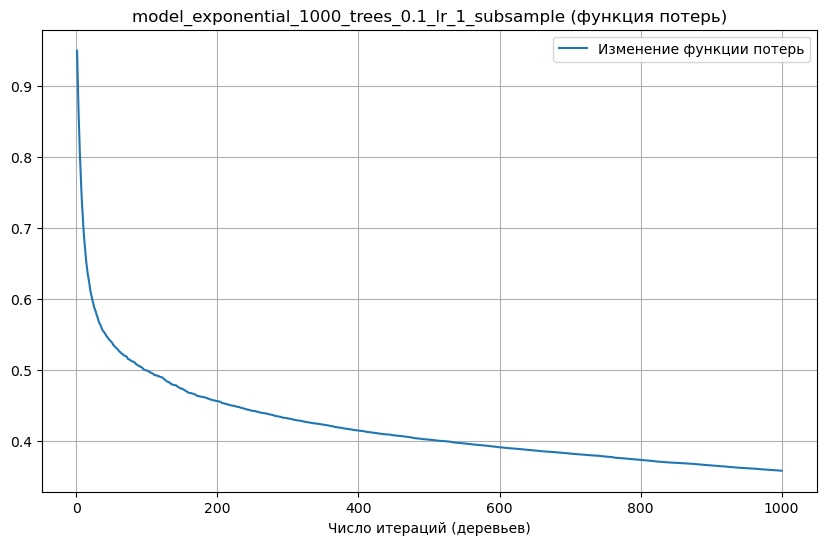

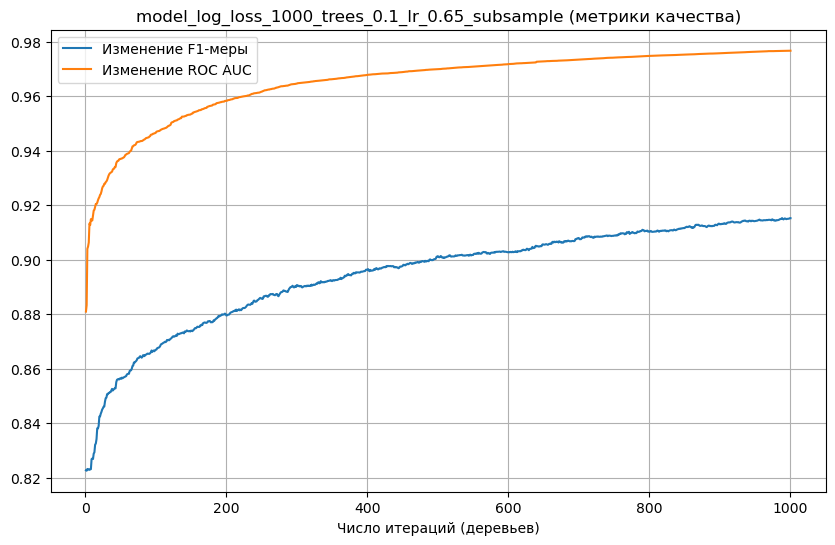

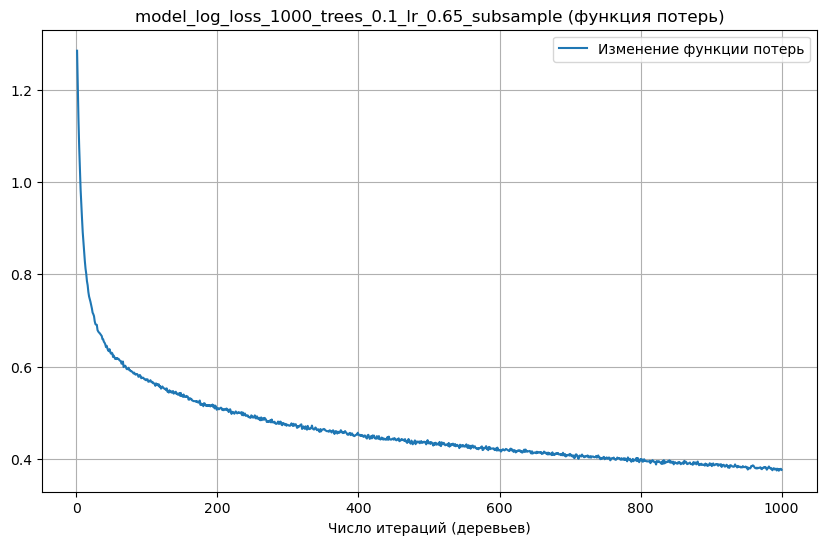

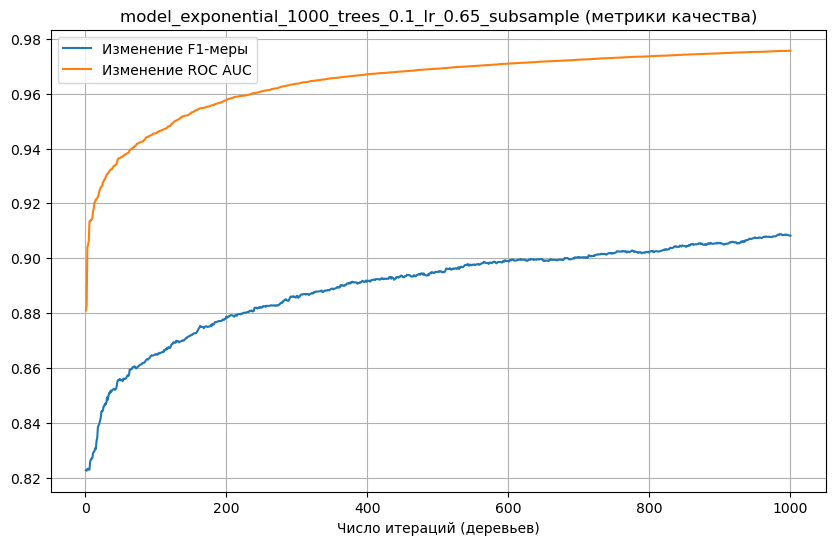

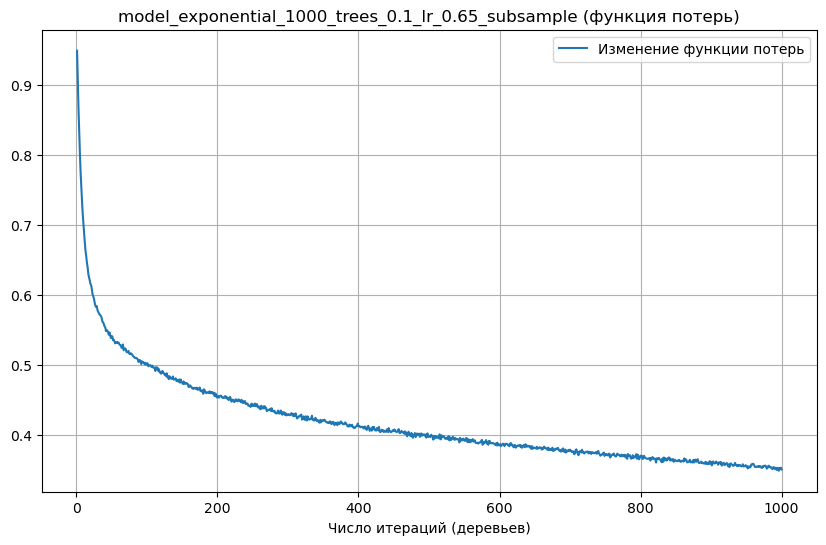

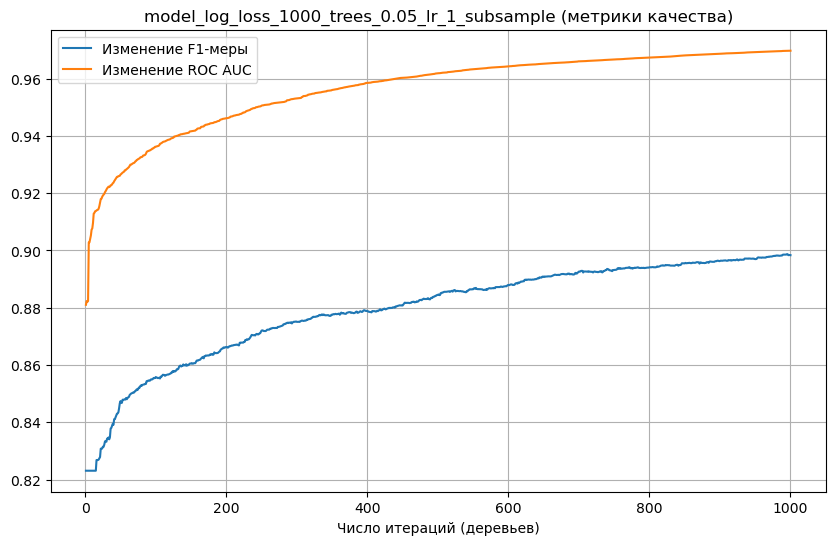

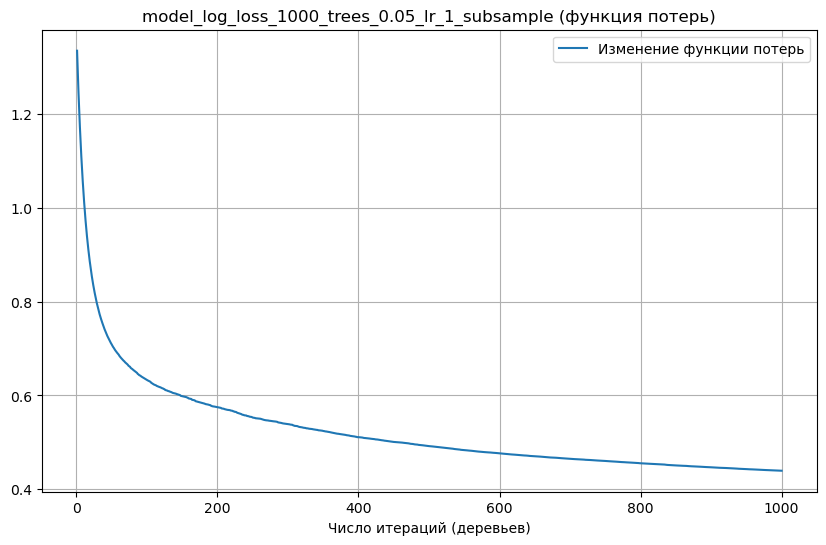

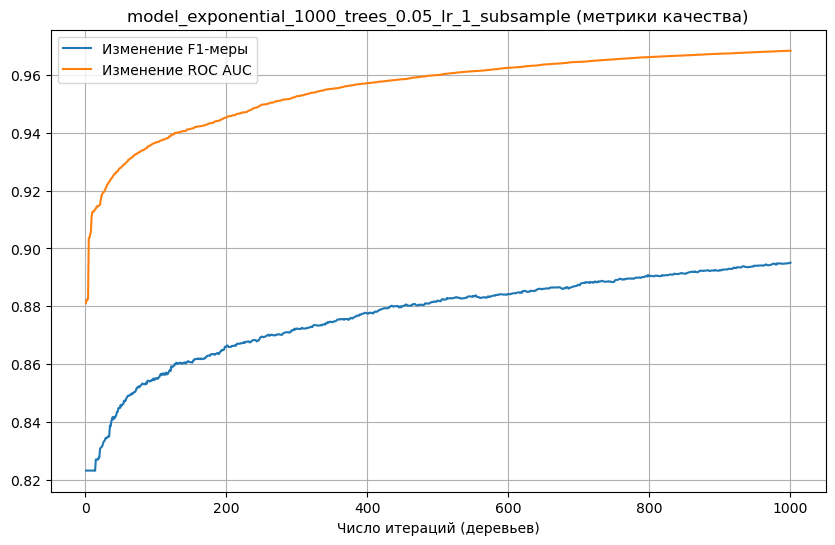

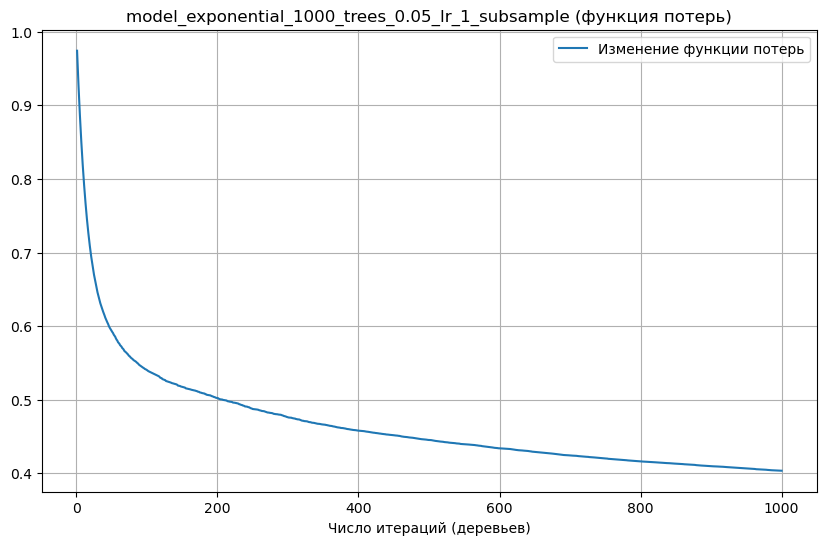

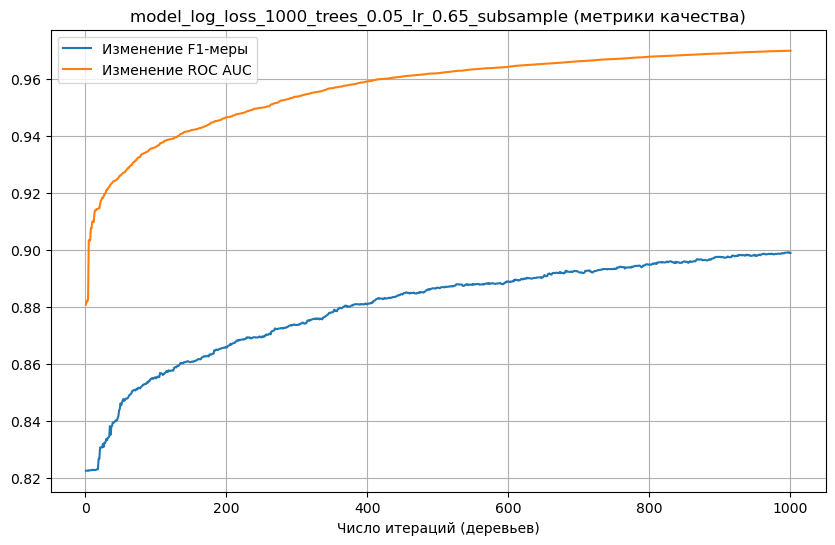

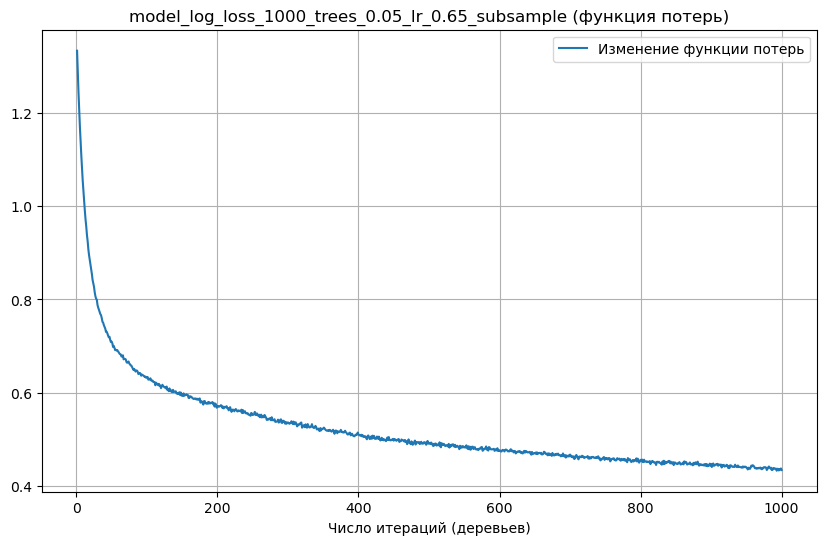

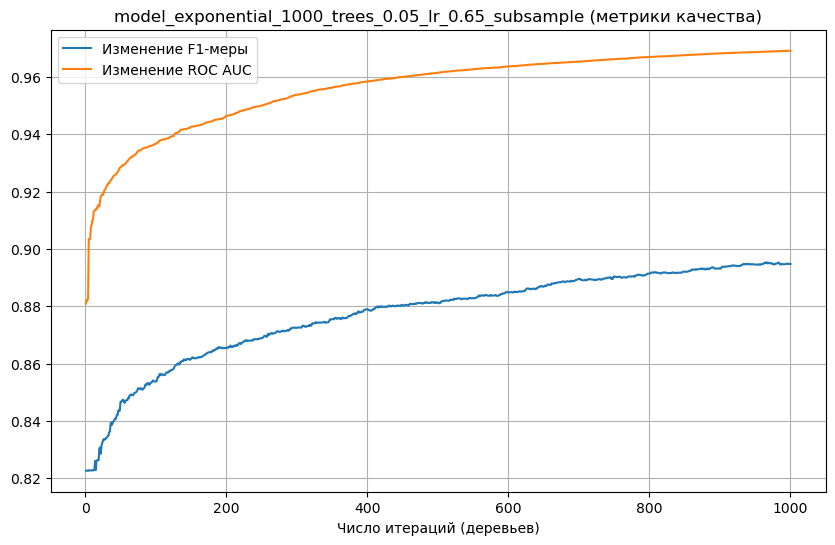

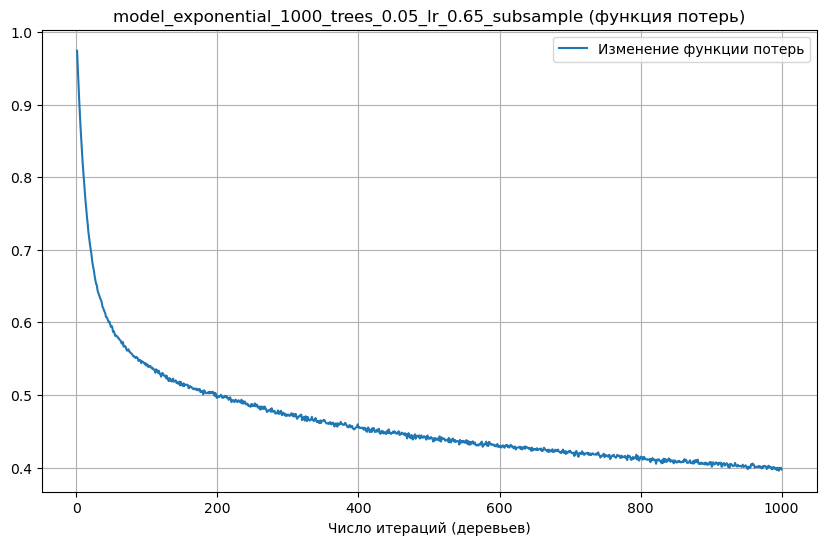

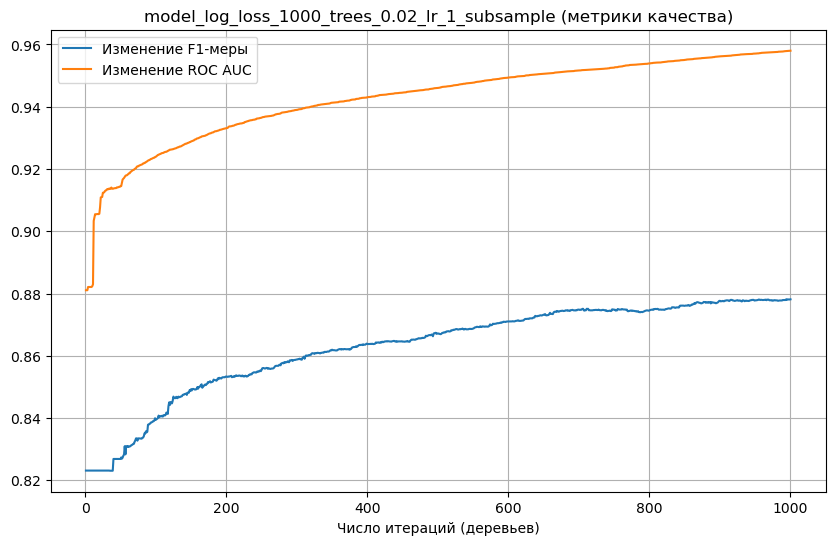

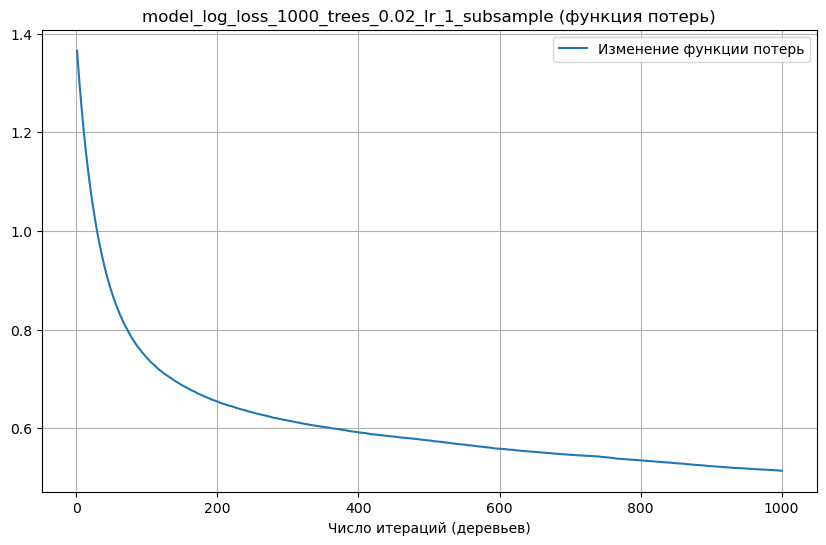

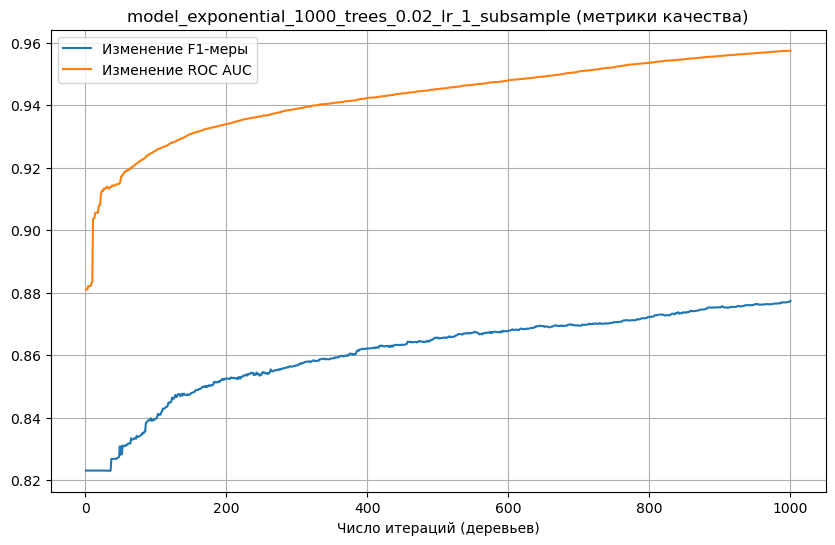

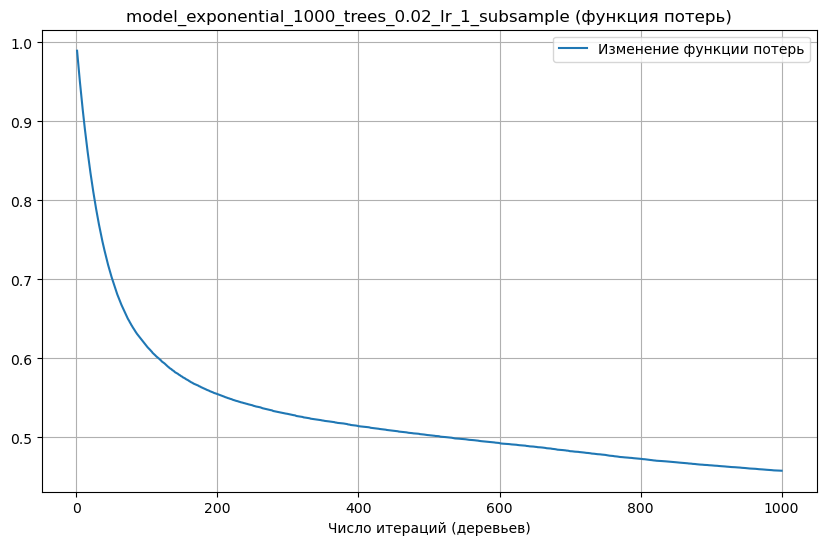

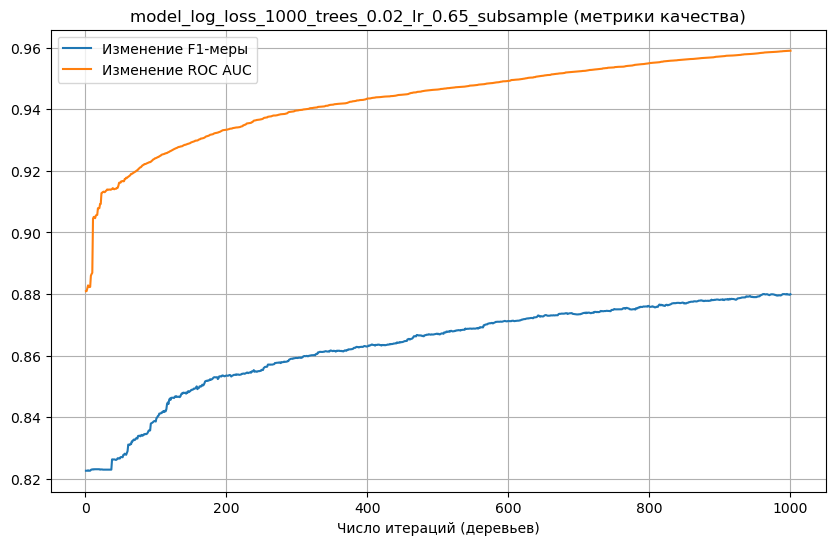

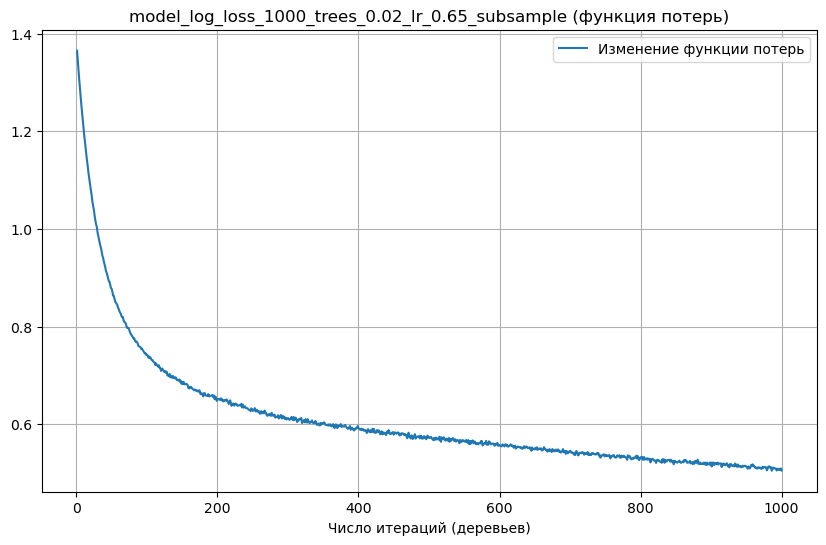

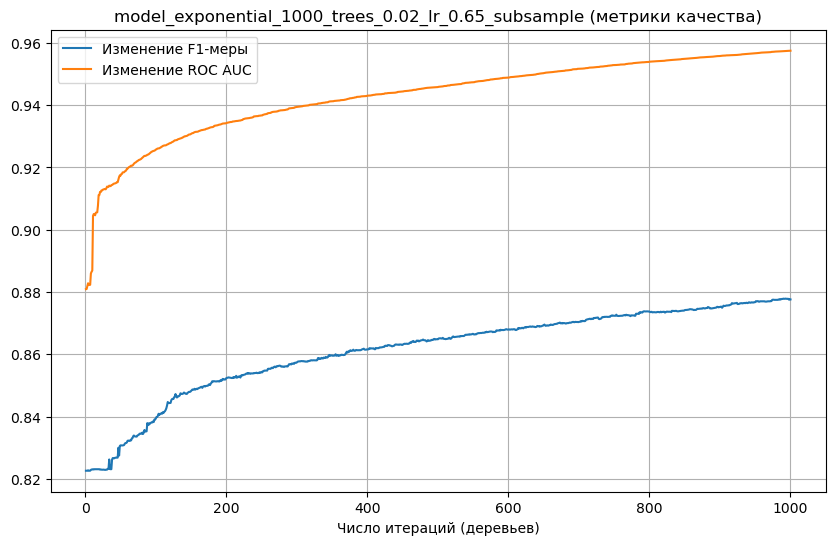

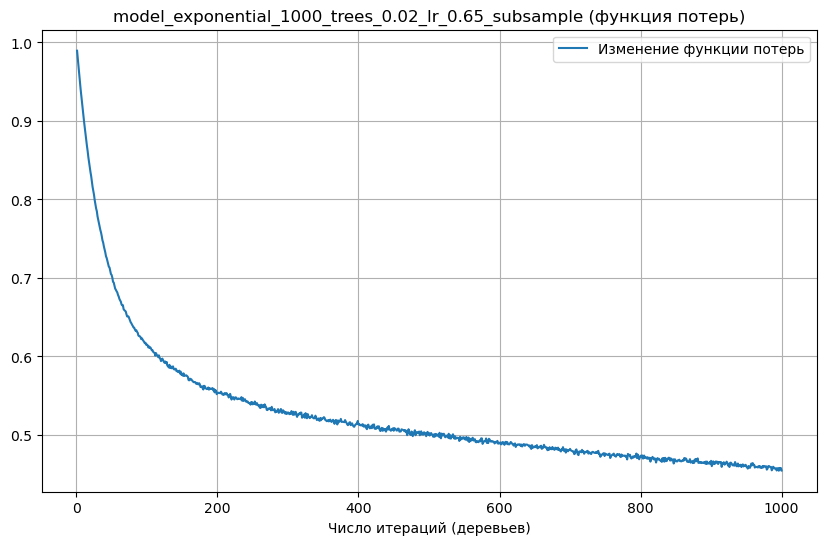

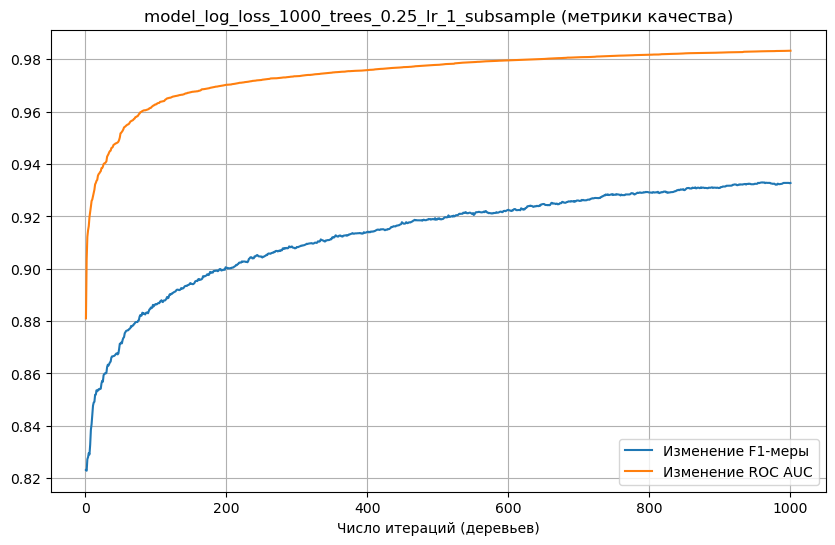

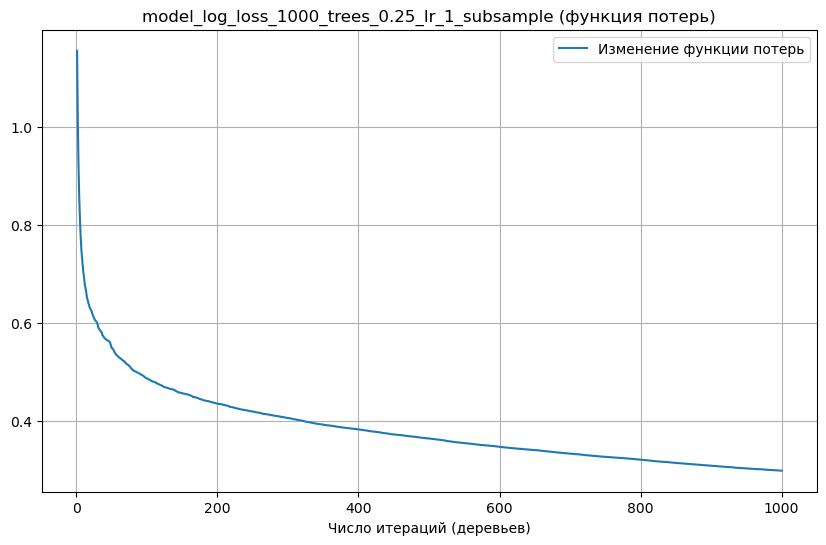

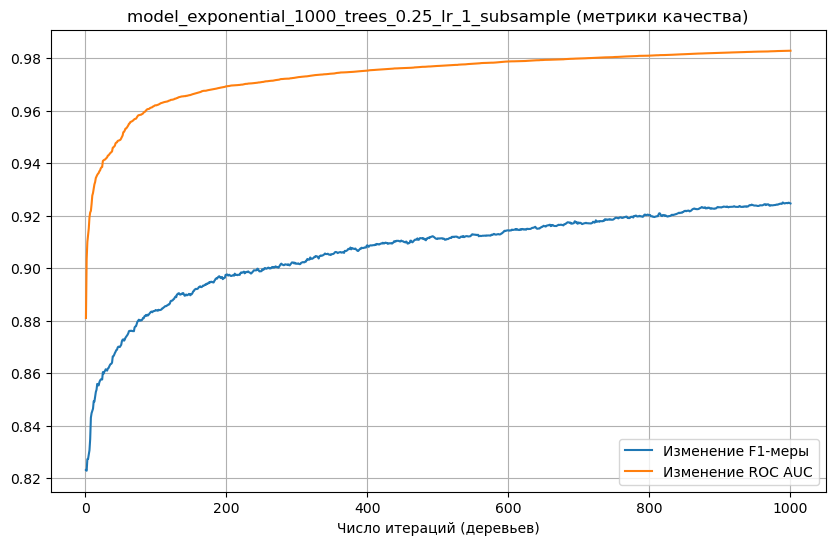

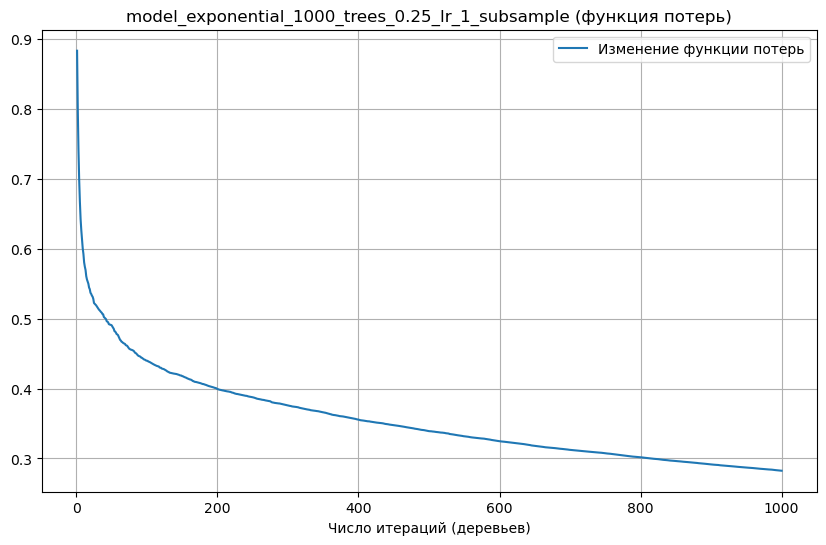

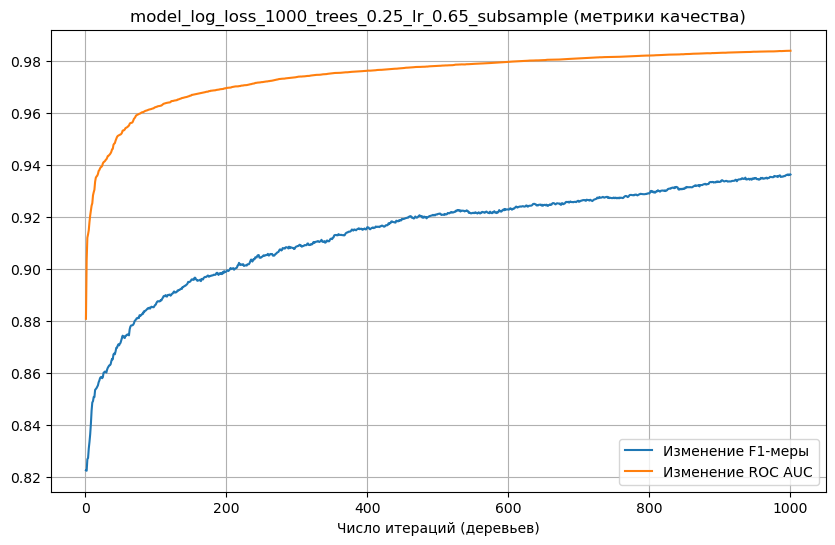

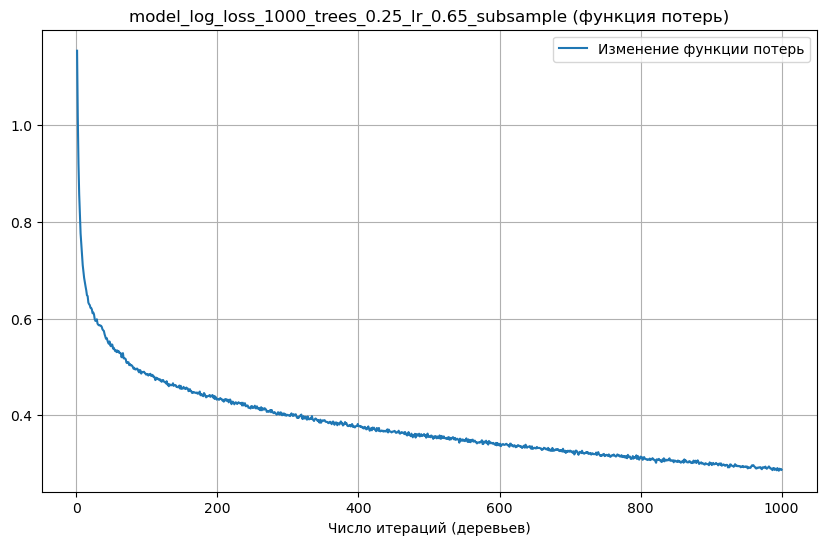

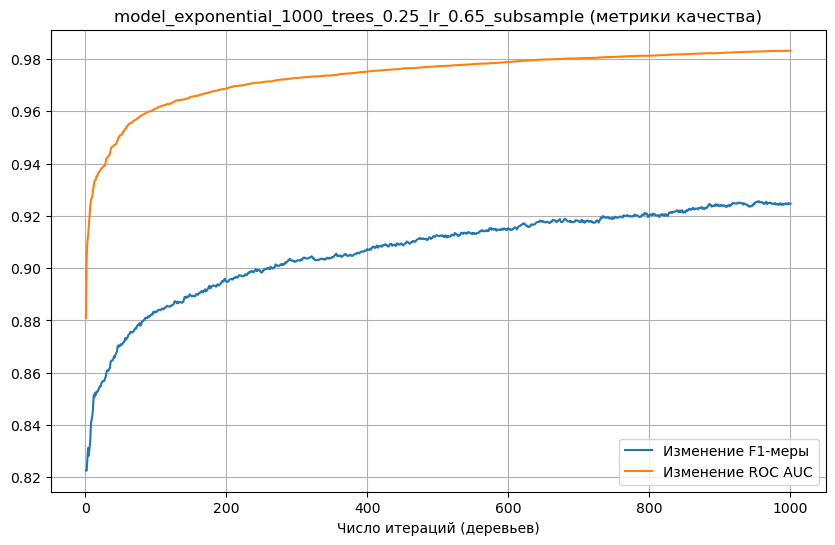

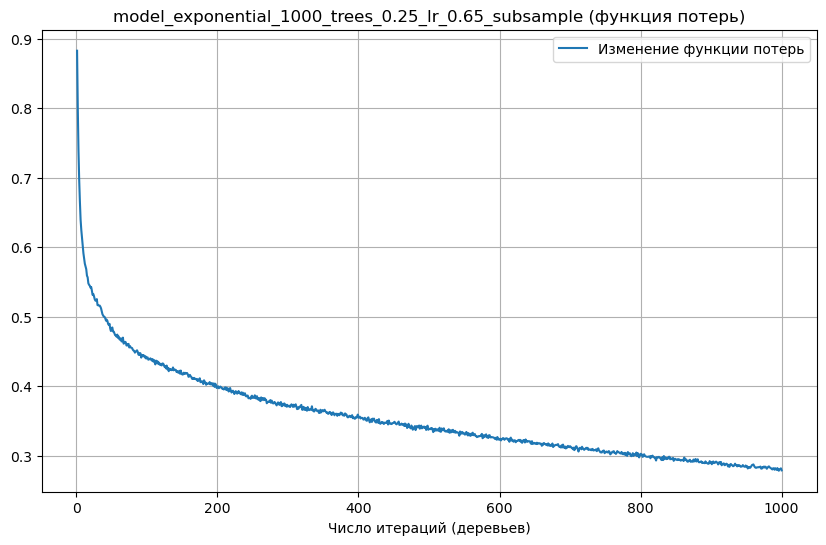

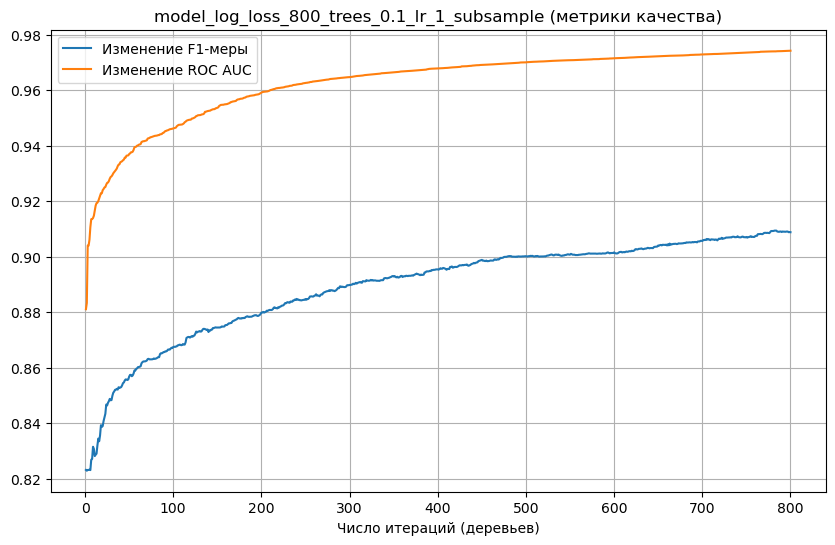

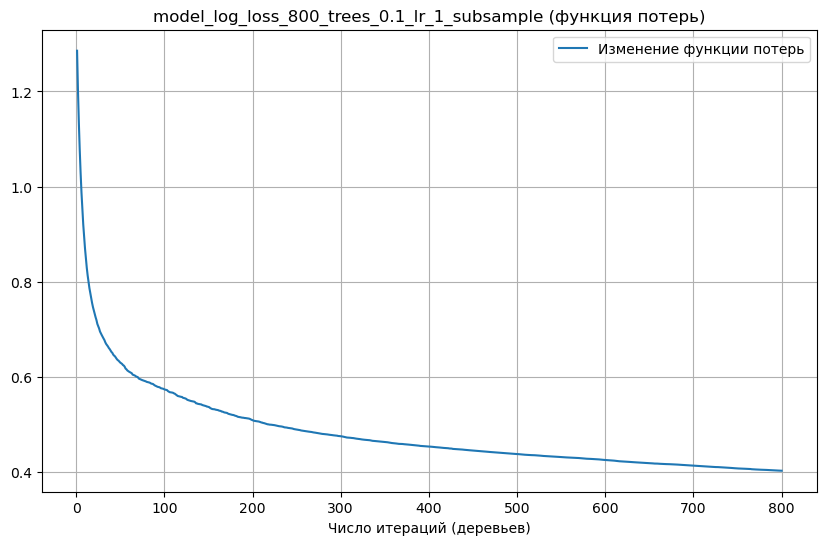

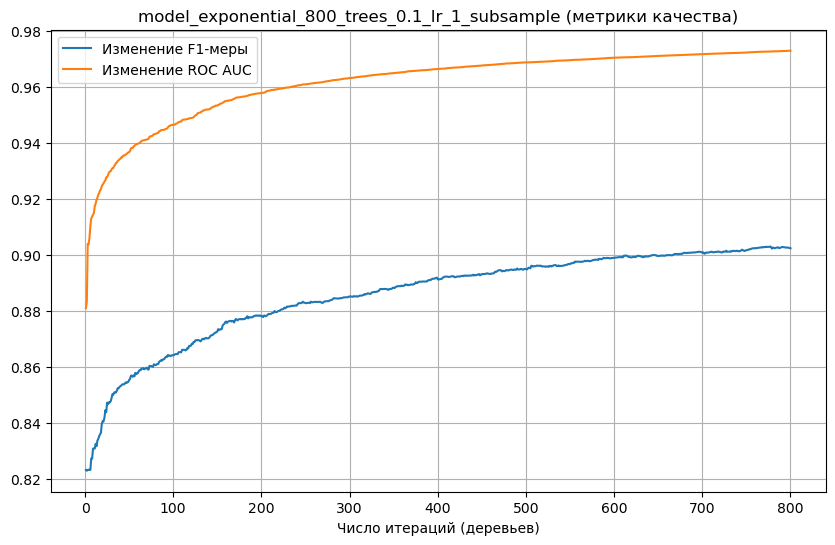

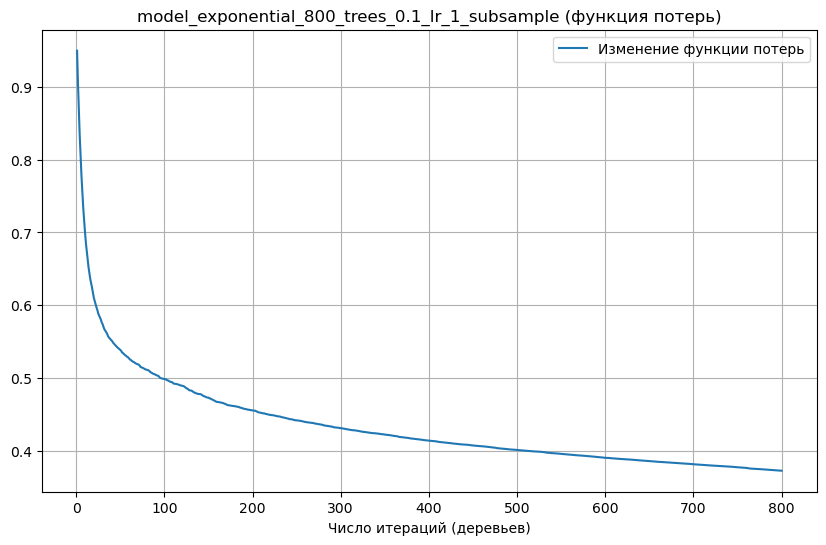

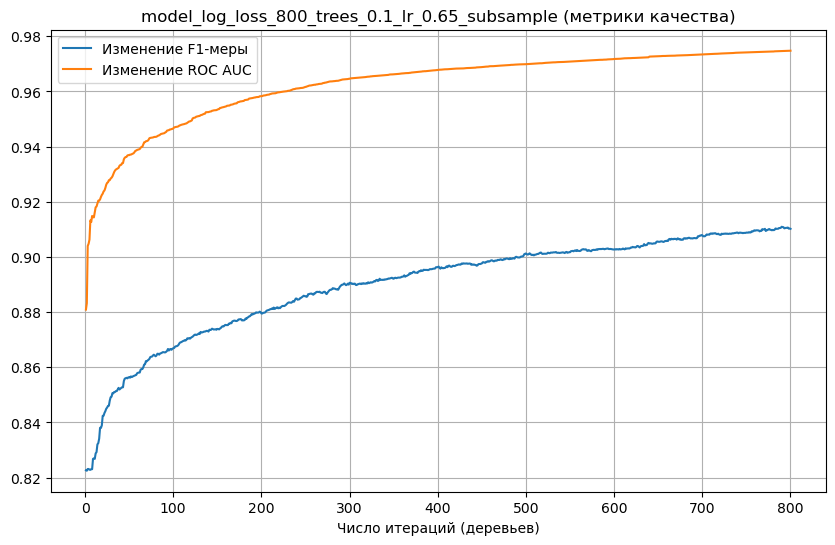

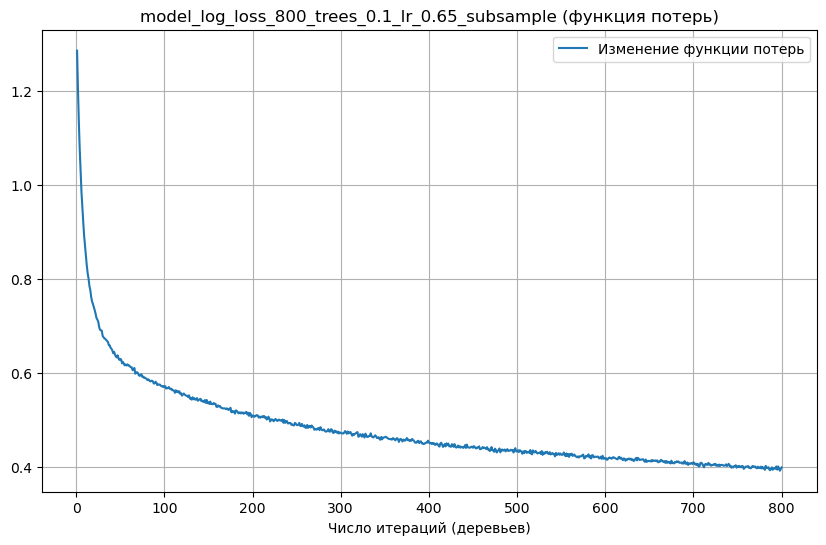

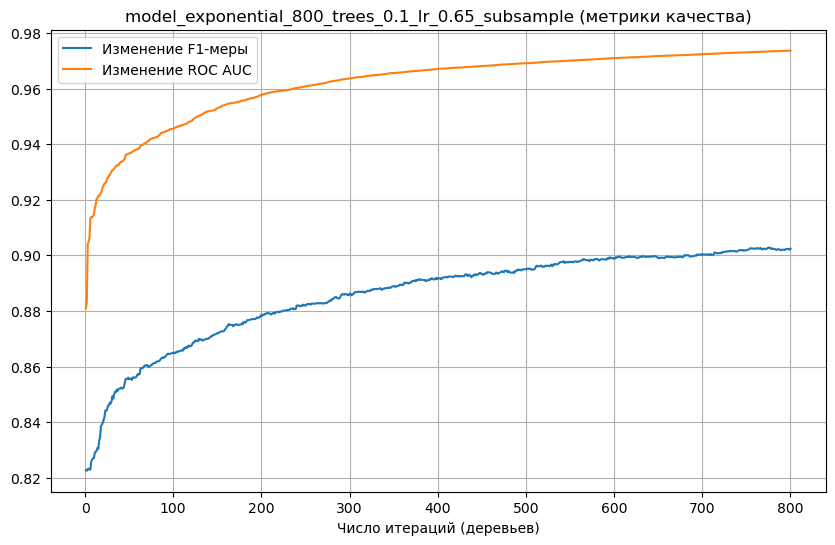

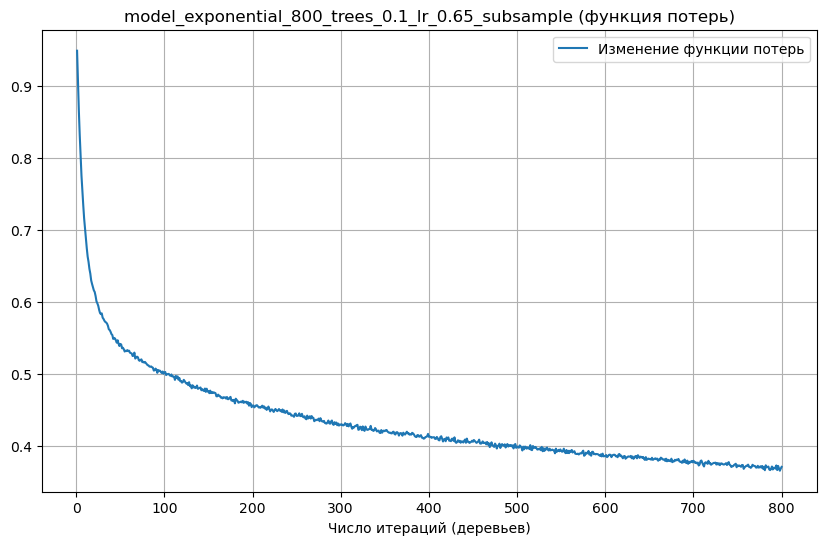

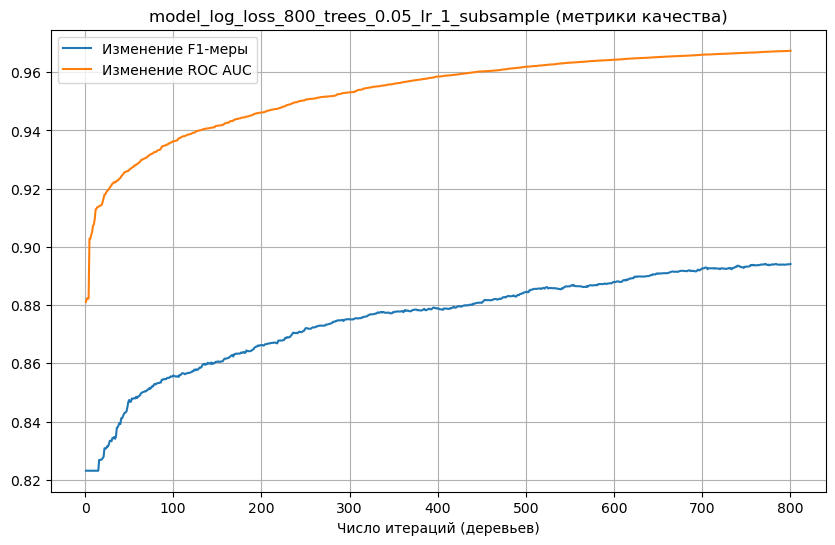

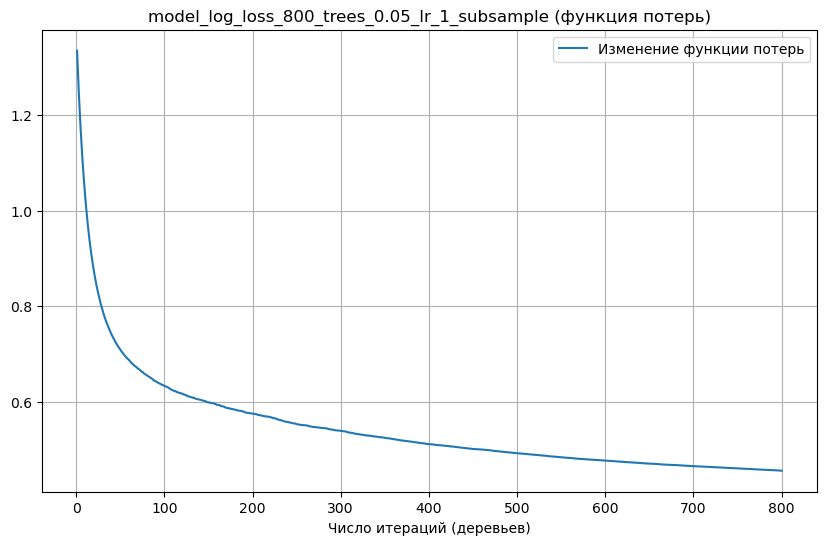

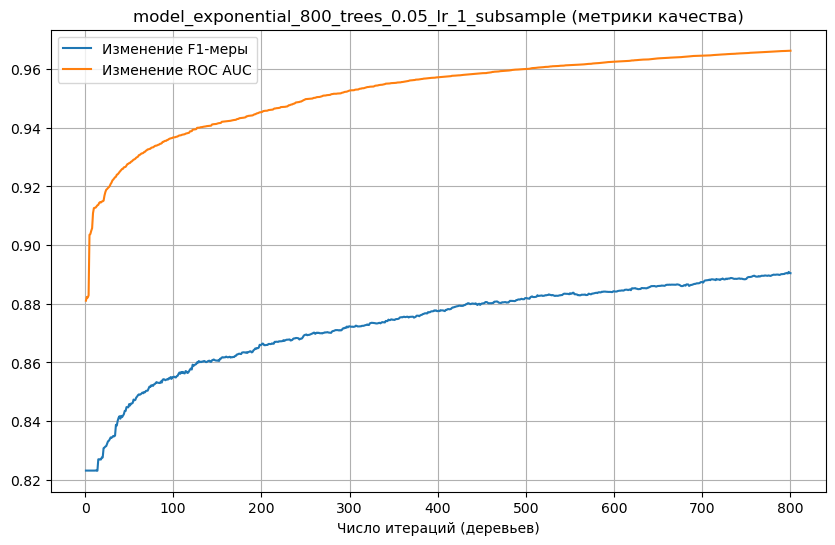

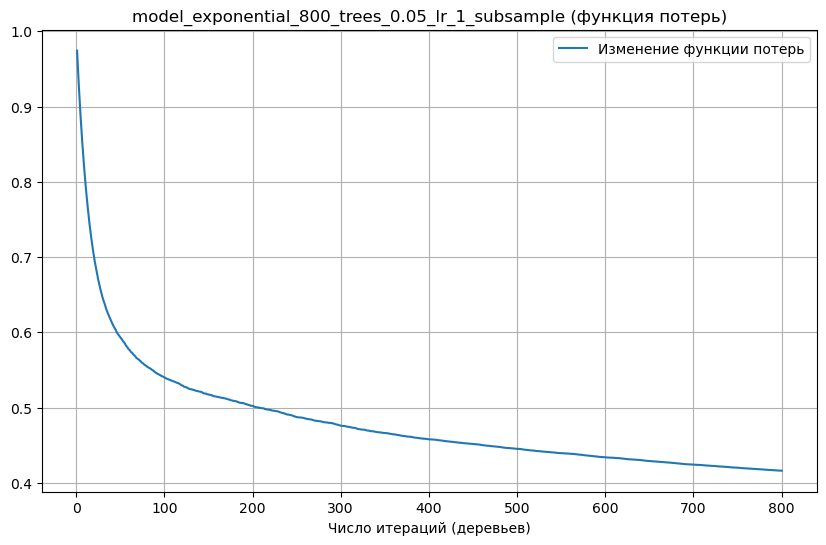

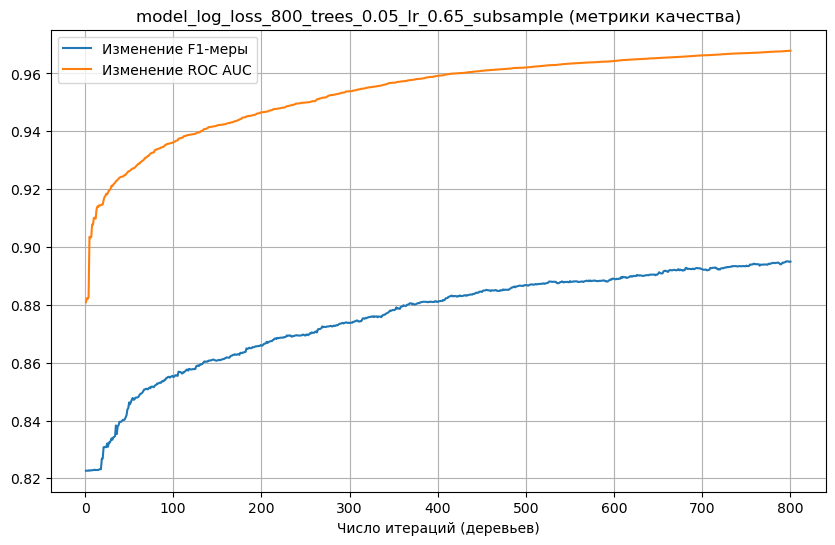

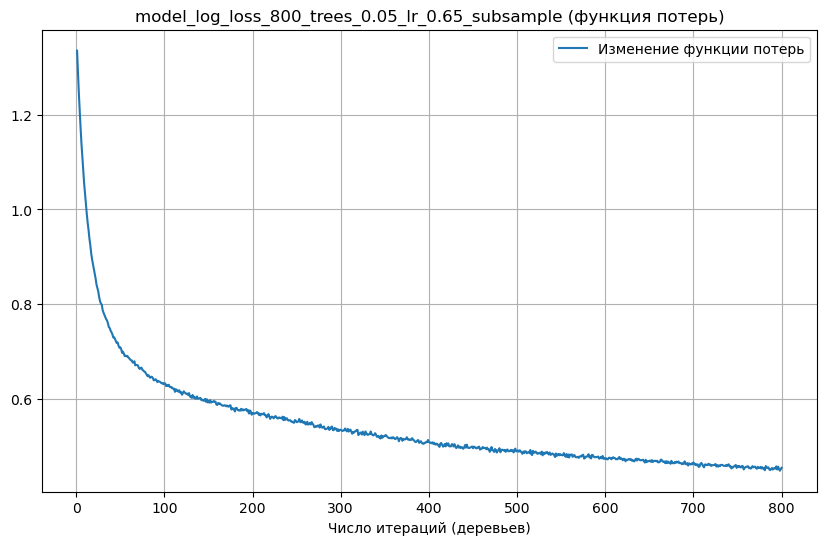

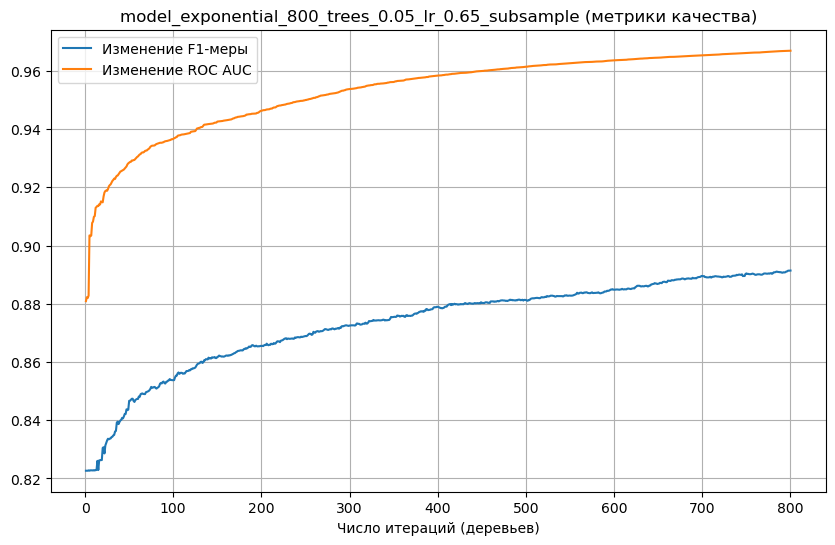

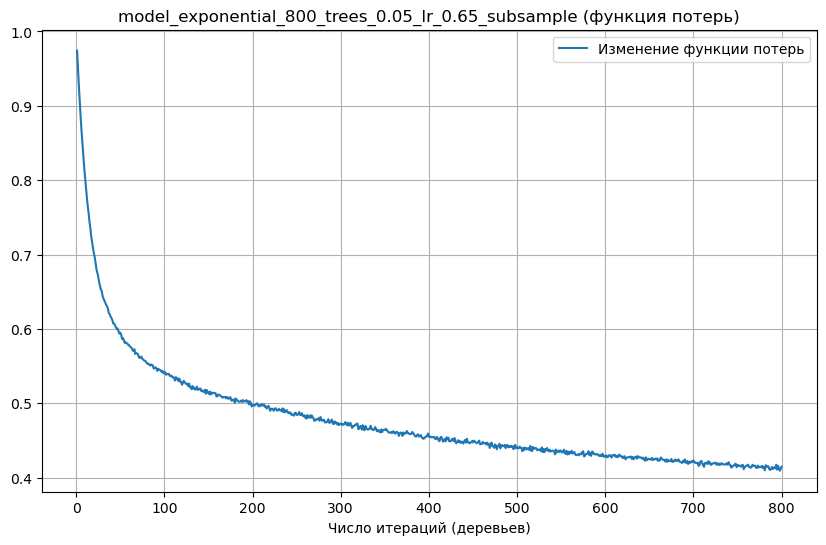

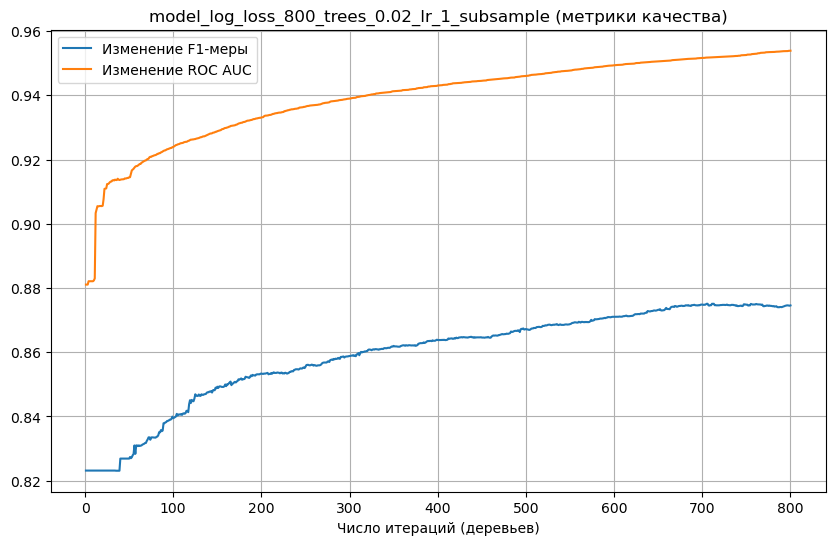

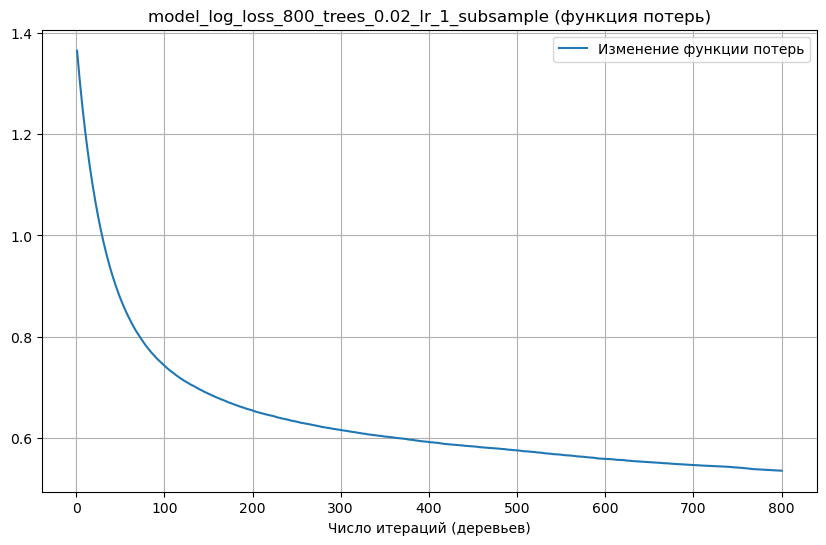

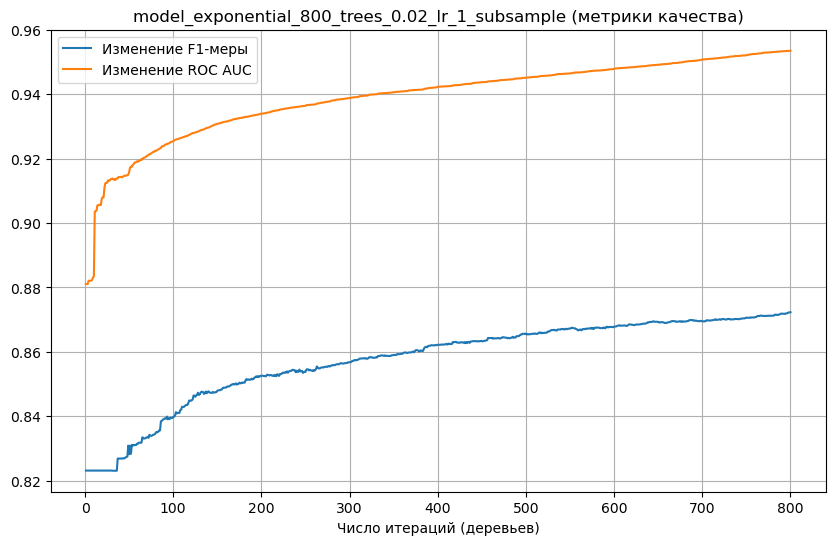

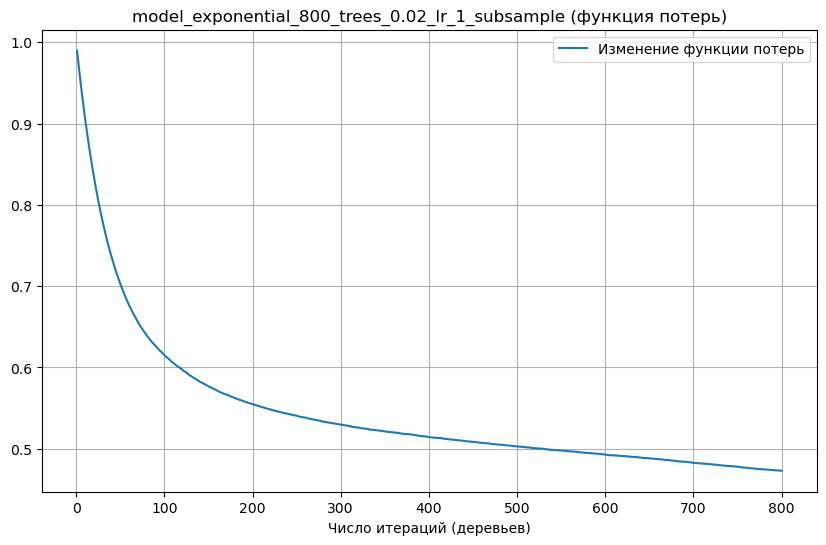

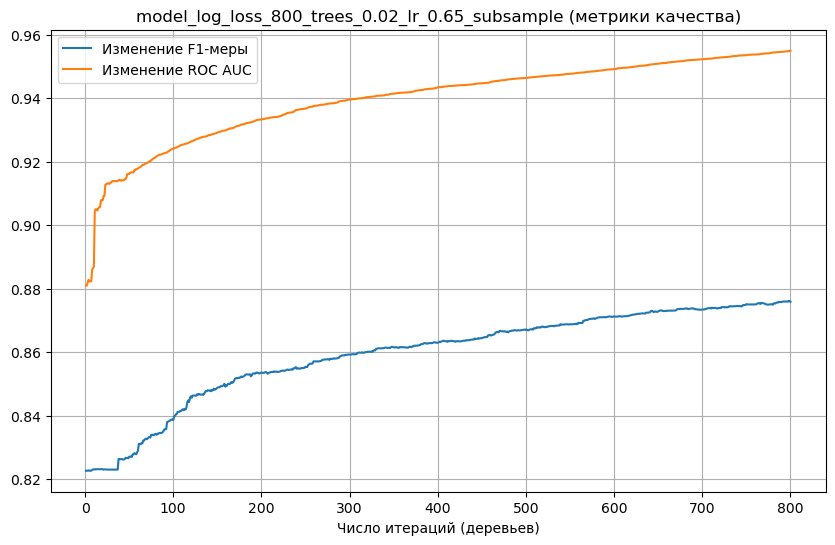

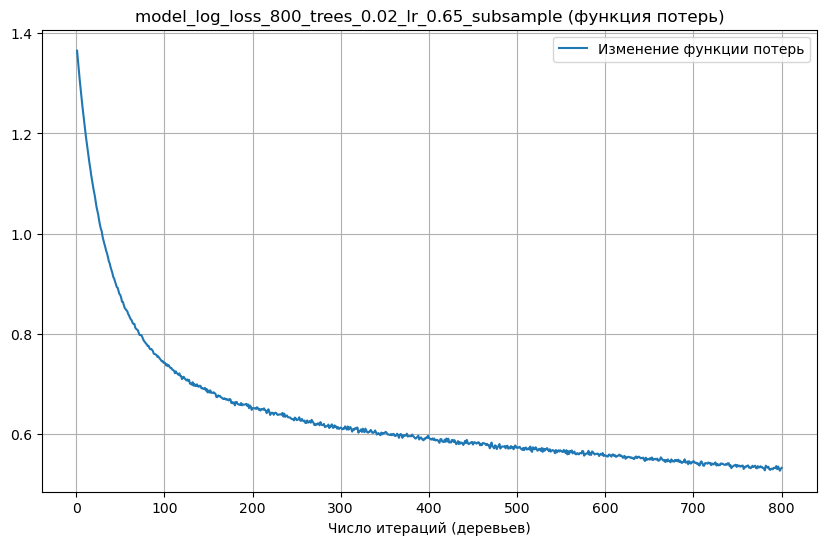

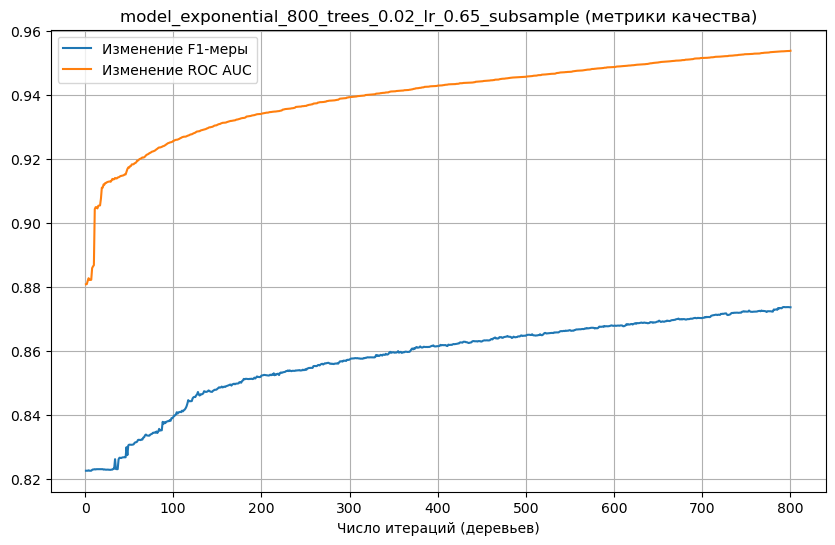

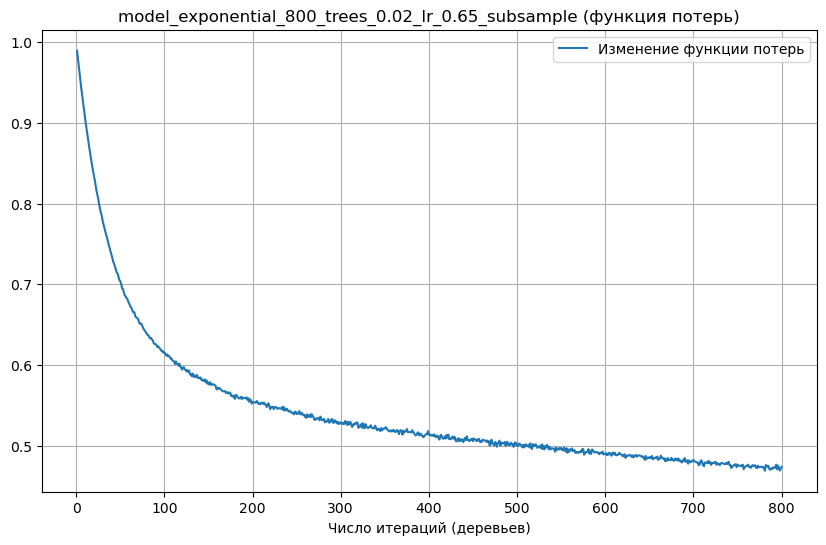

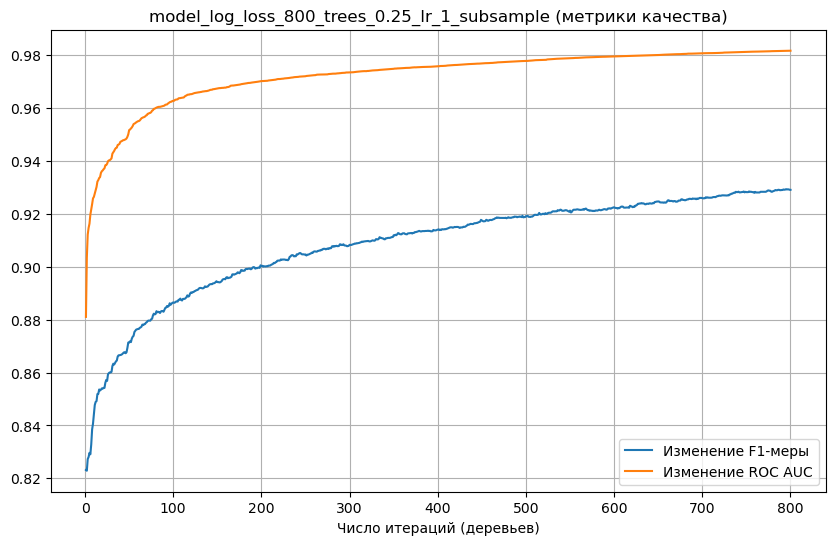

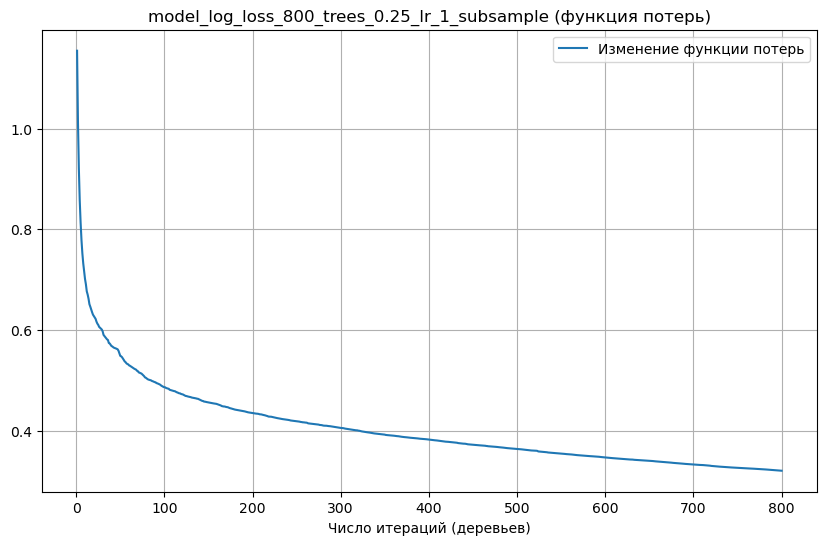

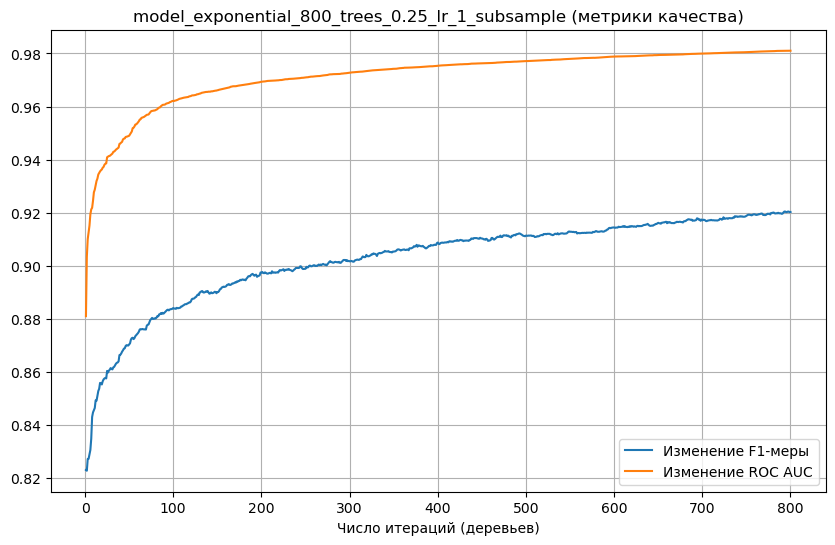

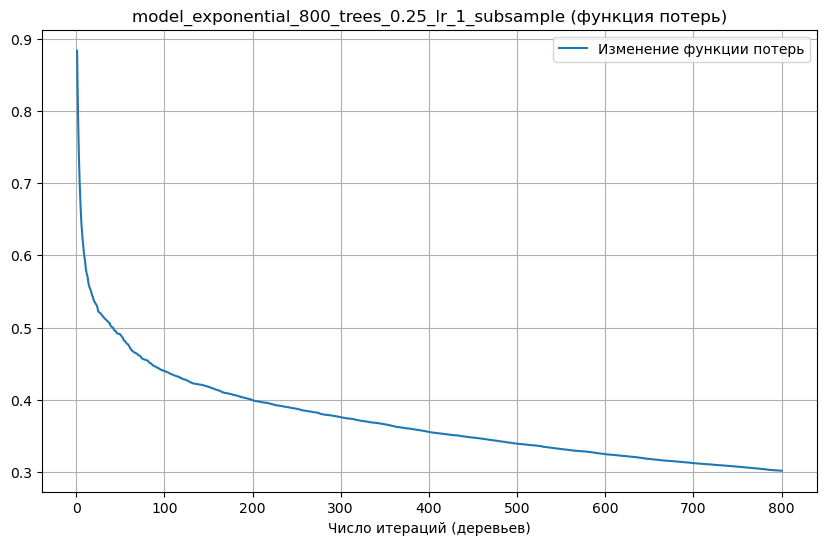

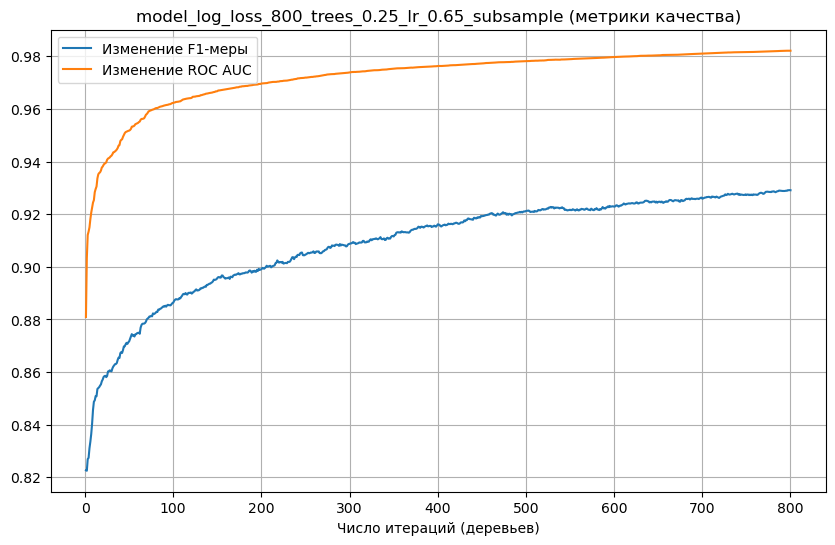

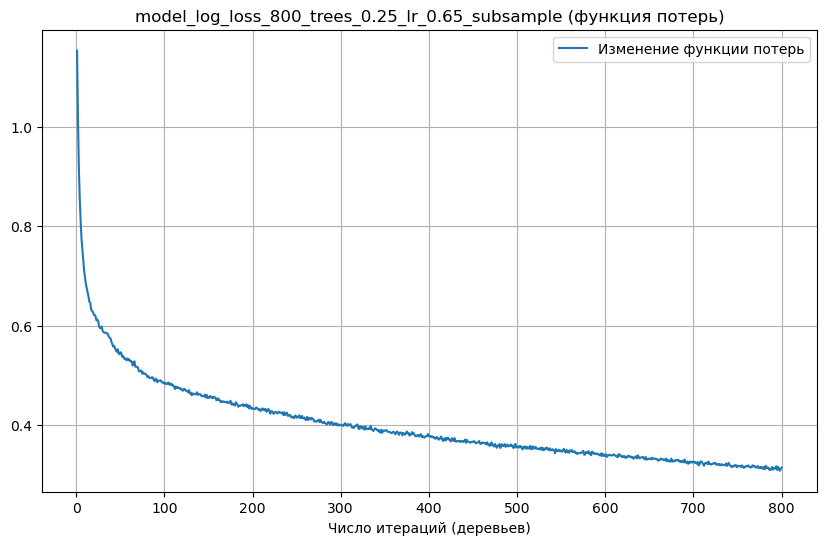

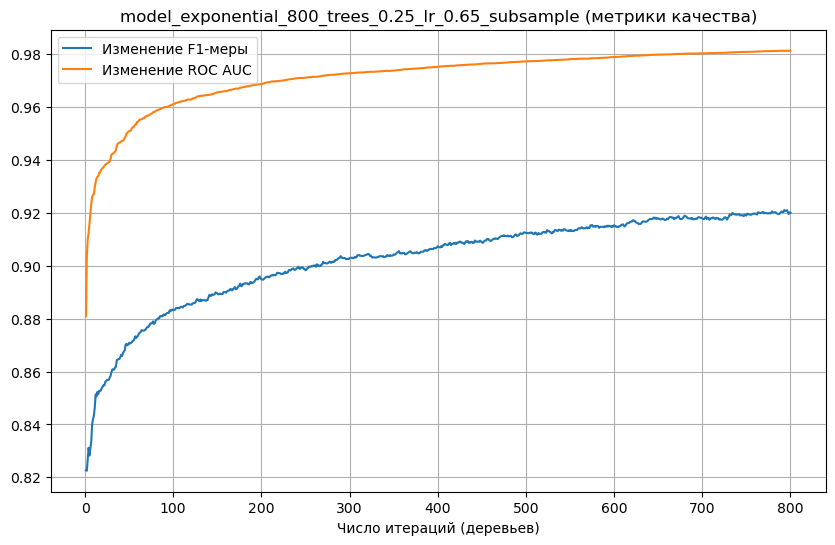

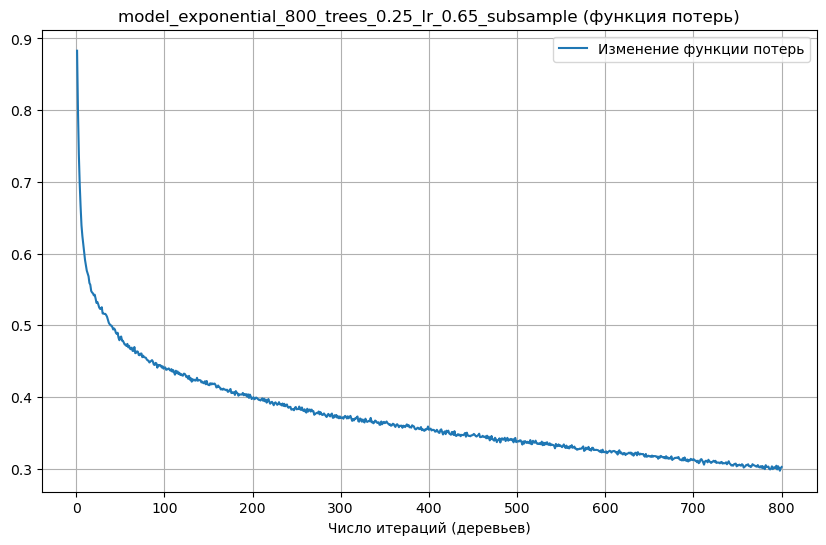

In [35]:
for model_info in training_report:
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(model_info.f1_score_history) + 1), model_info.f1_score_history, label="Изменение F1-меры")
    plt.plot(np.arange(1, len(model_info.roc_auc_history) + 1), model_info.roc_auc_history, label="Изменение ROC AUC")
    plt.xlabel("Число итераций (деревьев)")
    plt.title(f"{model_info.model_name} (метрики качества)")
    plt.legend()
    plt.grid()
   
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(model_info.loss_history) + 1), model_info.loss_history, label="Изменение функции потерь")
    plt.xlabel("Число итераций (деревьев)")
    plt.title(f"{model_info.model_name} (функция потерь)")
    plt.legend()
    plt.grid()
    plt.show()

Глобально по графикам можно заметить, что в самом начале обучения (маленькое число деревьев) наблюдается стремительное улучшение качества работы модели на тестовой выборке и падение значения функции потерь. Далее, примерно после 100-200 итераций, скорость изменения графиков уменьшается и с увеличением числа итераций они приближаются к плато

Также можно заметить, что большинство графиков моделей с subsample равным 1 плавные, в то время как при sumbample равном 0.65 наблюдаются небольшие колебания примерно после 100-й итерации

Чем выше learning_rate модели, тем быстрее она доходит до состояния плато как по качеству прогнозов на тестовой выборке, так и по изменению функции потерь. Однако можно заметить, что ни на одном из графиков не наблюдалось полного плато, а значит гипотетическое увеличение размера модели может показать лучший результат

Выбор функции потерь изменяет историю обучения не так сильно, как остальные гиперпараметры, однако стоит отметить, что немного лучший результат показывают модели, использующие log_loss в качестве функции потерь

Выделим наилучший классификатор (показавший наибольший ROC AUC score на тестовой выборке) и проанализируем его

In [36]:
best_classifier.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.25,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 0.65,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Построим на матрицы ошибок модели на тренировочной и тестовой выборках

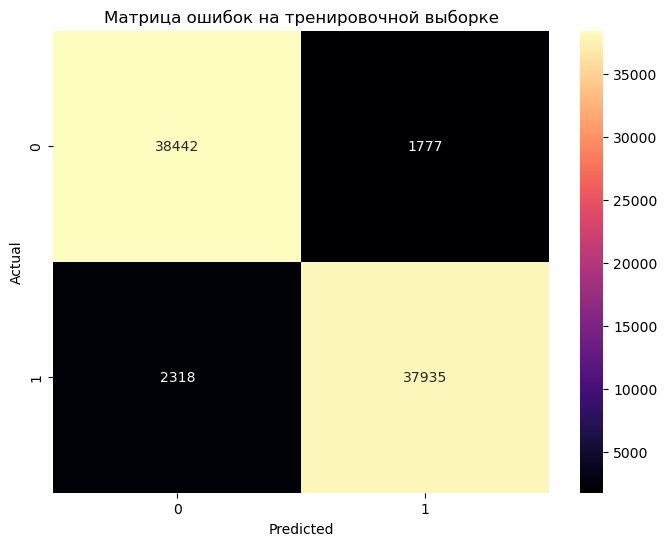

In [37]:
best_model_train_predictions = best_classifier.predict(X_train)
plot_confusion_matrix(y_train, best_model_train_predictions, title="Матрица ошибок на тренировочной выборке")

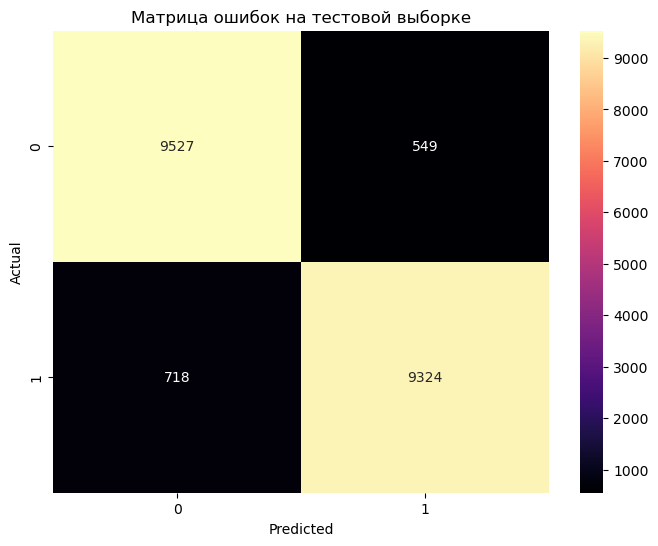

In [38]:
best_model_test_predictions = best_classifier.predict(X_test)
plot_confusion_matrix(y_test, best_model_test_predictions, title="Матрица ошибок на тестовой выборке")

Как видно, модель ошибается достаточно мало раз, ошибки между классами распределены примерно равномерно, что говорит о том, что проблема дисбаланса классов была решена

Сохраним лучший классификатор

In [39]:
import joblib

In [40]:
joblib.dump(best_classifier, 'models/best_gb_classifier.joblib')

['models/best_gb_classifier.joblib']

Протестируем работоспособность сохраненного классификатора

In [41]:
best_classifier = joblib.load('models/best_gb_classifier.joblib')

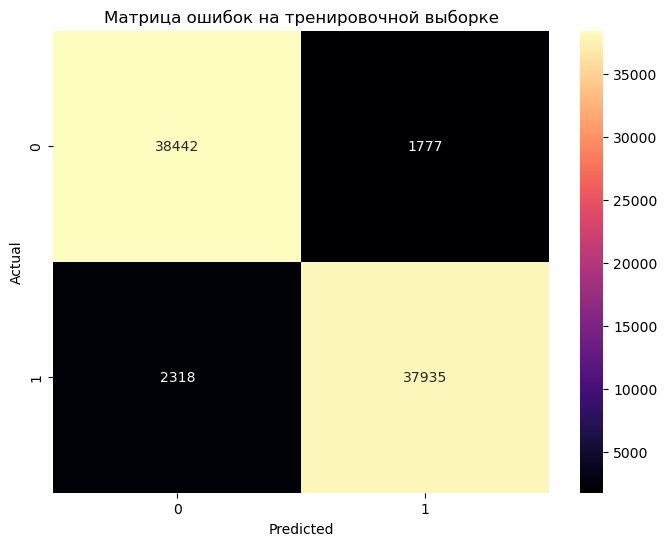

In [42]:
best_model_train_predictions = best_classifier.predict(X_train)
plot_confusion_matrix(y_train, best_model_train_predictions, title="Матрица ошибок на тренировочной выборке")

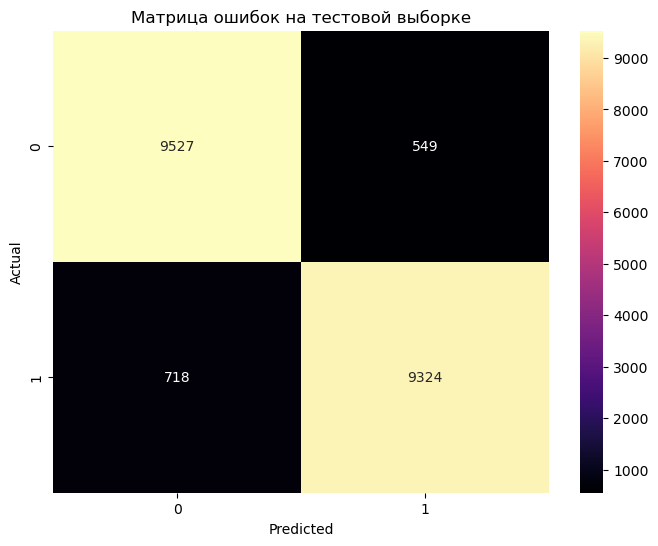

In [43]:
best_model_test_predictions = best_classifier.predict(X_test)
plot_confusion_matrix(y_test, best_model_test_predictions, title="Матрица ошибок на тестовой выборке")

Матрицы совпадают с полученными ранее, значит модель сохранилась успешно

Построим гистограмму влияния каждого из признаков на предсказанный ответ для лучшей модели

In [44]:
features = best_classifier.feature_names_in_
importances = best_classifier.feature_importances_

In [45]:
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feature_importances_df

Feature  Importance
0                          person_age    0.011271
1                       person_income    0.153393
2                   person_emp_length    0.016744
3                           loan_amnt    0.018701
4                       loan_int_rate    0.094418
5                 loan_percent_income    0.333108
6          cb_person_cred_hist_length    0.005466
7      person_home_ownership_MORTGAGE    0.003400
8         person_home_ownership_OTHER    0.000485
9           person_home_ownership_OWN    0.014253
10         person_home_ownership_RENT    0.053669
11      loan_intent_DEBTCONSOLIDATION    0.008411
12              loan_intent_EDUCATION    0.003188
13        loan_intent_HOMEIMPROVEMENT    0.013931
14                loan_intent_MEDICAL    0.006897
15               loan_intent_PERSONAL    0.002467
16                loan_intent_VENTURE    0.008858
17                 loan_grade_encoded    0.250486
18  cb_person_default_on_file_encoded    0.000856

In [46]:
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

Feature  Importance
5                 loan_percent_income    0.333108
17                 loan_grade_encoded    0.250486
1                       person_income    0.153393
4                       loan_int_rate    0.094418
10         person_home_ownership_RENT    0.053669
3                           loan_amnt    0.018701
2                   person_emp_length    0.016744
9           person_home_ownership_OWN    0.014253
13        loan_intent_HOMEIMPROVEMENT    0.013931
0                          person_age    0.011271
16                loan_intent_VENTURE    0.008858
11      loan_intent_DEBTCONSOLIDATION    0.008411
14                loan_intent_MEDICAL    0.006897
6          cb_person_cred_hist_length    0.005466
7      person_home_ownership_MORTGAGE    0.003400
12              loan_intent_EDUCATION    0.003188
15               loan_intent_PERSONAL    0.002467
18  cb_person_default_on_file_encoded    0.000856
8         person_home_ownership_OTHER    0.000485

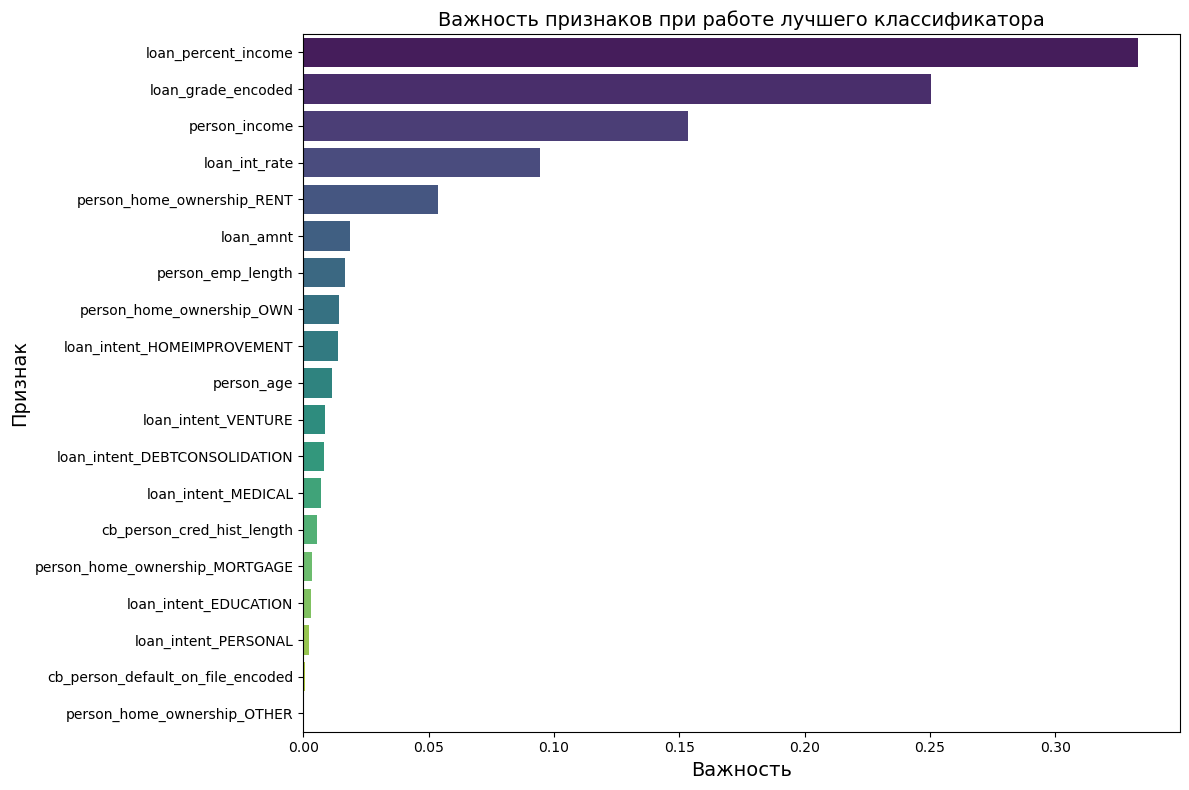

In [47]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')

plt.title('Важность признаков при работе лучшего классификатора', fontsize=14)
plt.xlabel('Важность', fontsize=14)
plt.ylabel('Признак', fontsize=14)

plt.tight_layout()
plt.show()

Наиболее важным оказалось отношение размера кредита к доходу заемщика (что логично, так как это комбинированная метрика), также важными являются категория риска кредита и непосредственный доход заемщика

Интересно, что исчезающе низкую оценку получило нахождение заемщика в базе данных кредитных дефолтов. Низкие оценки для цели кредита и владения недвижимостью можно объяснить разбиением этих признаков на dummy-столбцы

## Прогноз на тестовых данных

Загрузим тестовый датасет и предобработаем его так же, как и тренировочные данные

In [48]:
test_df = pd.read_csv(f"{data_path}/test.csv", index_col=0)
test_df.sample(10)

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                          
62986          22          36000                  RENT                6.0   
59852          23          65000              MORTGAGE                7.0   
90753          31          65000              MORTGAGE                5.0   
89285          25          75000                  RENT                2.0   
77223          28          50000                  RENT                2.0   
85477          28         120000              MORTGAGE               11.0   
88394          27         100000              MORTGAGE                5.0   
62759          26          68000              MORTGAGE                4.0   
90583          24          72000                  RENT                3.0   
90476          27          40000              MORTGAGE               11.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
id                                                              
62986            VENTURE          B      15000          10.59   
59852  DEBTCONSOLIDATION          B       3600          10.59   
90753    HOMEIMPROVEMENT          B       8000           9.99   
89285          EDUCATION          A      10000           8.49   
77223            MEDICAL          D      18000          15.62   
85477    HOMEIMPROVEMENT          B      12000          11.12   
88394    HOMEIMPROVEMENT          B      12000          11.99   
62759            VENTURE          C       3250          13.23   
90583          EDUCATION          B       7000           9.70   
90476            VENTURE          A       7200           7.29   

       loan_percent_income cb_person_default_on_file  \
id                                                     
62986                 0.42                         N   
59852                 0.06                         N   
90753                 0.12                         N   
89285                 0.13                         N   
77223                 0.36                         Y   
85477                 0.10                         N   
88394                 0.12                         N   
62759                 0.05                         Y   
90583                 0.10                         N   
90476                 0.18                         N   

       cb_person_cred_hist_length  
id                                 
62986                           2  
59852                           2  
90753                           5  
89285                           2  
77223                           6  
85477                           5  
88394                           6  
62759                           3  
90583                           4  
90476                           6

In [49]:
test_df.shape

(39098, 11)

In [50]:
test_df = pd.get_dummies(test_df, columns=one_hot_columns, drop_first=False)
test_df.sample(10)

person_age  person_income  person_emp_length loan_grade  loan_amnt  \
id                                                                          
87101          35          75000                1.0          B      20000   
92003          25          75000                1.0          C      12000   
80181          27          66000                0.0          D       6000   
81926          26          42000                8.0          B       3500   
82179          30         105000                2.0          C      15000   
93037          30         240000                3.0          B       4000   
71936          30          45000                0.0          B       8400   
74277          26          35000               10.0          C       7500   
80934          23          38400                7.0          B       5000   
94911          22          34000                1.0          C      10000   

       loan_int_rate  loan_percent_income cb_person_default_on_file  \
id                                                                    
87101          10.99                 0.27                         N   
92003          14.65                 0.16                         N   
80181          14.96                 0.09                         N   
81926          10.74                 0.09                         N   
82179          14.79                 0.14                         Y   
93037          10.75                 0.02                         N   
71936          11.58                 0.19                         N   
74277          13.92                 0.21                         Y   
80934          10.62                 0.13                         N   
94911          14.79                 0.29                         Y   

       cb_person_cred_hist_length  person_home_ownership_MORTGAGE  \
id                                                                  
87101                           8                           False   
92003                           4                           False   
80181                          10                           False   
81926                           4                            True   
82179                           5                           False   
93037                           8                            True   
71936                           6                            True   
74277                           2                           False   
80934                           3                           False   
94911                           2                           False   

       person_home_ownership_OTHER  person_home_ownership_OWN  \
id                                                              
87101                        False                      False   
92003                        False                      False   
80181                        False                      False   
81926                        False                      False   
82179                        False                      False   
93037                        False                      False   
71936                        False                      False   
74277                        False                      False   
80934                        False                      False   
94911                        False                      False   

       person_home_ownership_RENT  loan_intent_DEBTCONSOLIDATION  \
id                                                                 
87101                        True                           True   
92003                        True                          False   
80181                        True                          False   
81926                       False                          False   
82179                        True                          False   
93037                       False                          False   
71936                       False                          False   
74277  

In [51]:
test_df['loan_grade_encoded'] = ordinal_encoder.fit_transform(test_df[['loan_grade']])
test_df = test_df.drop('loan_grade', axis=1)
test_df.sample(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
id                                                                              
66178          24          40000                8.0       6000          10.36   
83400          26          28000               10.0       8000          13.61   
96532          25          62500                1.0      12000          16.00   
81267          25          50000                9.0      11500           6.03   
80394          26          30000                1.0       5000          10.33   
78544          22          55000                6.0      10000          11.49   
69611          22          72000                6.0      12000           7.88   
81809          28          50000                1.0       5000           9.63   
70509          25          40000                4.0      10000          15.99   
69079          27          90000               11.0      10000          11.71   

       loan_percent_income cb_person_default_on_file  \
id                                                     
66178                 0.15                         N   
83400                 0.29                         Y   
96532                 0.19                         N   
81267                 0.23                         N   
80394                 0.17                         N   
78544                 0.18                         N   
69611                 0.17                         N   
81809                 0.10                         N   
70509                 0.25                         Y   
69079                 0.11                         N   

       cb_person_cred_hist_length  person_home_ownership_MORTGAGE  \
id                                                                  
66178                           2                            True   
83400                           2                           False   
96532                           4                           False   
81267                           4                            True   
80394                           3                           False   
78544                           4                            True   
69611                           3                           False   
81809                           5                           False   
70509                           4                           False   
69079                           6                           False   

       person_home_ownership_OTHER  person_home_ownership_OWN  \
id                                                              
66178                        False                      False   
83400                        False                      False   
96532                        False                      False   
81267                        False                      False   
80394                        False                      False   
78544                        False                      False   
69611                        False                      False   
81809                        False                       True   
70509                        False                      False   
69079                        False                      False   

       person_home_ownership_RENT  loan_intent_DEBTCONSOLIDATION  \
id                                                                 
66178                       False                          False   
83400                        True                          False   
96532                        True                           True   
81267                       False                          False   
80394                        True                          False   
78544                       False                          False   
69611                        True                          False   
81809                       False                          False   
70509                        True                          False   
690

In [52]:
test_df['cb_person_default_on_file_encoded'] = test_df['cb_person_default_on_file'].map({'N': False, 'Y': True})
test_df = test_df.drop('cb_person_default_on_file', axis=1)
test_df.sample(10)

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
id                                                                              
77592          32         115000               11.0       7000           7.14   
95817          30          91392               14.0      18000          13.98   
64986          22          54996                6.0       5000           6.92   
75935          24          49200                8.0       6000          13.72   
60992          27         120000                3.0      12000          13.49   
92390          28          65000                0.0       4000           7.74   
60521          21          34500                2.0      10000          14.38   
95621          28          90000                5.0       9500          11.71   
64734          24          31000                0.0       8000          13.23   
97081          28          30000                2.0       3000          15.70   

       loan_percent_income  cb_person_cred_hist_length  \
id                                                       
77592                 0.06                           5   
95817                 0.19                           5   
64986                 0.09                           2   
75935                 0.12                           3   
60992                 0.10                           9   
92390                 0.06                           9   
60521                 0.29                           2   
95621                 0.11                           8   
64734                 0.27                           2   
97081                 0.10                           7   

       person_home_ownership_MORTGAGE  person_home_ownership_OTHER  \
id                                                                   
77592                            True                        False   
95817                           False                        False   
64986                           False                        False   
75935                            True                        False   
60992                           False                        False   
92390                           False                        False   
60521                           False                        False   
95621                            True                        False   
64734                           False                        False   
97081                           False                        False   

       person_home_ownership_OWN  person_home_ownership_RENT  \
id                                                             
77592                      False                       False   
95817                      False                        True   
64986                      False                        True   
75935                      False                       False   
60992                      False                        True   
92390                      False                        True   
60521                      False                        True   
95621                      False                       False   
64734                      False                        True   
97081                      False                        True   

       loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
id                                                            
77592                          False                   True   
95817                          False                  False   
64986                          False                   True   
75935                          False                   True   
60992                          False                  False   
92390                           True                  False   
60521                          False                  False   
95621                          False                  False   
64734                          False                  False   
97081                           Tr

Выделим вероятности положительного класса для тестовых данных

In [53]:
predictions = best_classifier.predict_proba(test_df)[:, 1]
predictions

array([0.99986809, 0.12581607, 0.90372736, ..., 0.00651003, 0.30390751,
       0.99712102])

Запишем их вместе с id экземпляра в датафрейм, и сохраним для отправки на Kaggle

In [54]:
submission_df = pd.DataFrame({'id': test_df.index, 
                              'loan_status': predictions})
submission_df.head(10)

id  loan_status
0  58645     0.999868
1  58646     0.125816
2  58647     0.903727
3  58648     0.025015
4  58649     0.041665
5  58650     0.994911
6  58651     0.001576
7  58652     0.011401
8  58653     0.398468
9  58654     0.012973

In [55]:
submission_df.to_csv(f'{data_path}/submission.csv', index=False)

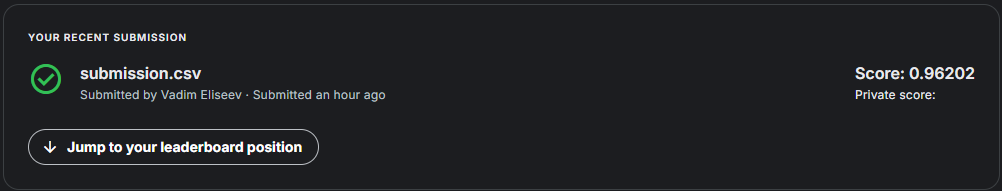

Как видно, натренированный нами классификатор хорошо справился с тестовыми данными, показав ROC AUC score превосходящий 96%

## Улучшение полученной модели путем калибровки вероятностных предсказаний

Попробуем улучшить качество нашей модели с помощью калибровки выходных вероятностей классификатора (имеет место, поскольку в контексте соревнования оцениваются именно предсказанные моделью вероятности)

In [56]:
calibrated_clf = CalibratedClassifierCV(estimator=best_classifier)

In [57]:
calibrated_clf.fit(X_train, y_train)
calibrated_clf.get_params()

{'base_estimator': 'deprecated',
 'cv': None,
 'ensemble': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.25,
 'estimator__loss': 'log_loss',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 1000,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 42,
 'estimator__subsample': 0.65,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingClassifier(learning_rate=0.25, n_estimators=1000,
                            random_state=42, subsample=0.65),
 'method': 'sigmoid',
 'n_jobs': None}

Посмотрим на качество полученной модели

In [58]:
pd.DataFrame(evaluate_calibrated_model(model=calibrated_clf, model_name='calibrated_best_clf', 
                                       train_data=X_train, y_train=y_train, test_data=X_test, y_test=y_test)).T

model_name train_score  train_f1 train_roc_auc test_score  \
0  calibrated_best_clf    0.948541  0.947918      0.989319   0.936177   

    test_f1 test_roc_auc  
0  0.935073     0.984403

И еще раз на лучшую базовую модель

In [59]:
training_report.to_frame().head(1)

model_name  train_score  train_f1  \
14  model_log_loss_1000_trees_0.25_lr_0.65_subsample     0.949113   0.94879   

    train_roc_auc  test_score  test_f1  test_roc_auc  
14       0.989079    0.937022  0.93638      0.983978

Как видим, ROC AUC score откалиброванной модели немного лучше, значит имеет смысл проверить ее качество на тестовых данных

Построим на матрицы ошибок для откалиброванной модели

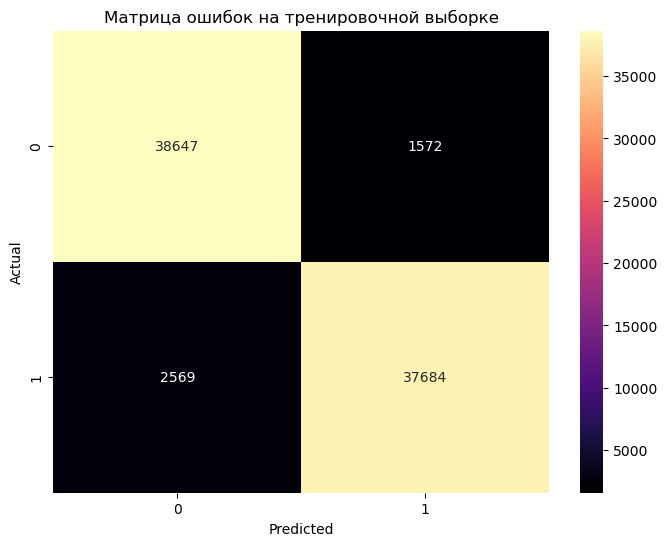

In [60]:
calibrated_model_train_predictions = calibrated_clf.predict(X_train)
plot_confusion_matrix(y_train, calibrated_model_train_predictions, title="Матрица ошибок на тренировочной выборке")

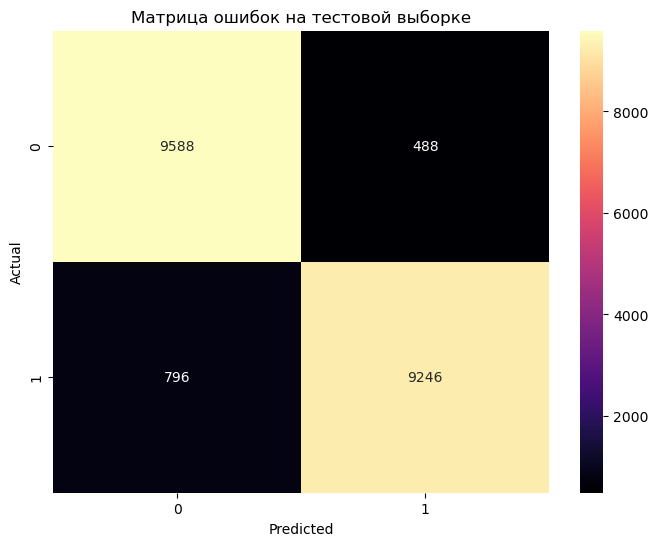

In [61]:
calibrated_model_test_predictions = calibrated_clf.predict(X_test)
plot_confusion_matrix(y_test, calibrated_model_test_predictions, title="Матрица ошибок на тестовой выборке")

Модель стала работать чуть лучше, в частности модель допускает меньше ошибок в предсказании негативного класса

Построим прогноз на тестовых данных

In [62]:
predictions = calibrated_clf.predict_proba(test_df)[:, 1]
predictions

array([0.7420656 , 0.30807193, 0.63061195, ..., 0.28548504, 0.4844483 ,
       0.72327211])

И, как ранее, запишем в csv для отправки на Kaggle

In [63]:
submission_df = pd.DataFrame({'id': test_df.index, 
                              'loan_status': predictions})
submission_df.head(10)

id  loan_status
0  58645     0.742066
1  58646     0.308072
2  58647     0.630612
3  58648     0.291357
4  58649     0.294087
5  58650     0.718579
6  58651     0.255342
7  58652     0.278618
8  58653     0.549603
9  58654     0.282204

In [64]:
submission_df.to_csv(f'{data_path}/submission.csv', index=False)

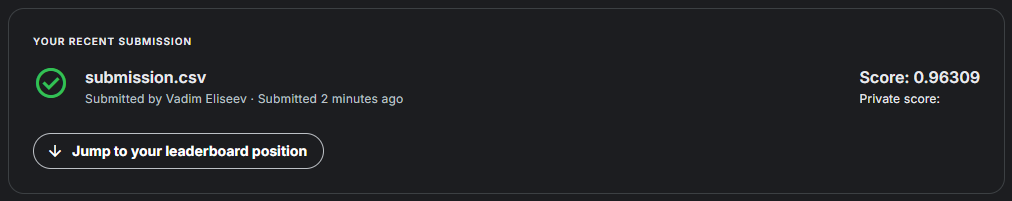

Использование калибровки помогло увеличить финальную оценку модели примерно на 0.1%, что в контексте соревнования на Kaggle, достаточно хороший результат

Сохраним откалиброванный классификатор

In [65]:
joblib.dump(calibrated_clf, 'models/calibrated_gb_classifier.joblib')

['models/calibrated_gb_classifier.joblib']